In [2]:
import numpy as np
import pandas as pd
import gzip
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD

from textblob import TextBlob


import string
import re
from nltk.stem.porter import PorterStemmer

%matplotlib inline

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Summary

In this project, we explored San Diego Airbnb listings data in 2019-11, built models to recommend price for hosts/customers.

We did EDA and data preparation for Listing data in Section 1, and for Calendar data in Section 2.
* **1. Listing Data Preparation**
    
    * *General EDA and data preparation*
            1.1 General Exploration
            1.2 Data Cleaning
    * *Y-variable (exploration, defining, and transformation)*
            1.3 Explore Price
            1.4 Explore Occupancy
    * *X-variables (we defined 5 types of X-variables and did feature extraction and encoding accordingly)*
            1.5 Explore House Information Variables (some one-hot encoding)
            1.6 Explore Location Data (Geo)
            1.7 Explore Listing Descriptive Variables (NLP)
                * Basic Features
                * TF-IDF
                * Doc2Vec
                * Sentiment Analysis
                
            1.8 Explore Host Variables (some one-hot encoding)
            1.9 Explore Review Variables (NLP)
                * Basic Features
                * TF-IDF
                * Doc2Vec
                * Sentiment Analysis
* **2. Calendar Data Preparation**
* **3. Before Building Models**
    * *Did some final preparation before building the models*
        
            3.1 Final check
                * Deleting unwanted columns
                * Additional data encoding
                * Data type conversion
                * Missing value imputation
                
            3.2 Train-validation-test Splitting (0.75-0.15-0.10)
            3.3 Data Scaling/Standardization
            3.4 Export ready-to-go dataset as csv 
* **4. Building Models**
    * *Built 7 models*
            
            4.1 LASSO
            4.2 SVR (Support Vector Regression)
            4.3 RF (Random Forest)
            4.4 Gradient Boost
            4.5 Ada Boost
            4.6 KNNR (K-Nearest-Neighbor Regression)
            4.6 DNN (Deep Learning Neural Network)
* **5. Model Evaluation**
    * *We compared different model's performance based on their R-Square and MSE. **Gradient Boost (R-square: 0.74)** shows the best result. Random Forest also gives decent result. Lasso Regression serves as our base model (R-square: 0.66). Deep learning doesn't perform well due to the limited data size.*


* **6. Feature Importance**
    * *We ranked feature importance and discovered that*
    
            6.1 From LASSO
            6.2 From Random Forest
     
        * LASSO and Random Forest shows relatively consistent feature importance ranking
            * The most important two types of features are:
            * The most important features are **House Basic Info** (*# accommodates, # bedrooms, whether it is entire apt, private room, and the bathroom_bedroom ratio* we created)
        * The second most important features are **Location Info** (*distance to landscapes like La Jolla, Sea World, Sunset Cliff, Balboa Park, Torrey Beach, Convention Center*)
        * *The Number of Reviews Per Month* from **Reviews Info** is an important predictor based on both method.
        * Based on RF, **Listing Description Info** like *Length of Name, Length of Summary* are also important. Based on LASSO, **Hosts Information** like *Reply time, Listing Count* are important. We think it is because these hosts are more serious about renting their houses and put more thoughts and time.



# 1. Listing Data Preparation
We are using (San Diego, latest scraped data 2019-11-21) for exploration purpose.

## 1.1 General Exploration

In [2]:
path = "/Users/yuxinzhang/Personal Project/222/SanDiego_data/"

In [3]:
# listings = pd.read_csv("http://data.insideairbnb.com/united-states/ca/san-diego/2019-11-21/data/listings.csv.gz",
#                      compression='gzip',
#                      low_memory=False)
listings = pd.read_csv(path + "listings.csv")
listings.head()

/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (43,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,5570,https://www.airbnb.com/rooms/5570,20191121092222,2019-11-21,Ocean front condo on the sand,Missionbeachretreat. Great Ocean Front Condo...,This charming two bedroom beachfront condomini...,Missionbeachretreat. Great Ocean Front Condo...,none,While some may compare San Diego’s Mission Bea...,NaN,Bus #8 goes to La Jolla and Old Town transit c...,"2 Bedrooms (1 Queen, 2 Twins) 1 Bath Balcony ...",Once reservation is made I will call guest. I...,"Min 4 nights winter. 7 nights Spring Break, l...",NaN,NaN,https://a0.muscache.com/im/pictures/d3342744-1...,NaN,8435,https://www.airbnb.com/users/show/8435,Jef Karchin,2009-02-23,"San Diego, California, United States","Real estate broker, Jef Karchin real estate ...",within a few hours,100%,NaN,f,https://a0.muscache.com/im/users/8435/profile_...,https://a0.muscache.com/im/users/8435/profile_...,Mission Beach,3.0,3.0,"['email', 'phone', 'kba']",t,t,"San Diego, CA, United States",Mission Beach,Mission Bay,NaN,San Diego,CA,92109,San Diego,"San Diego, CA",US,United States,32.78430,-117.25258,t,Condominium,Entire home/apt,6,1.0,2.0,4.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Free par...",850.0,"$2,050.00",NaN,NaN,$500.00,$150.00,1,$0.00,3,365,3,3,365,365,3.0,365.0,2 months ago,t,12,20,31,176,2019-11-21,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,"{""SAN DIEGO"","" SAN DIEGO TOURISM MARKETING DIS...",f,f,strict_14_with_grace_period,f,f,2,2,0,0,NaN
1,8488,https://www.airbnb.com/rooms/8488,20191121092222,2019-11-21,Juniper Zen Palace- SD's Best Hood!,Walk every where in San Diegos most charming a...,Private craftsman home in the heart of Histori...,Walk every where in San Diegos most charming a...,none,South Park is a charming community and our nei...,we have no cable tv. just streaming services. ...,bus route to downtown is 1/2 block away!,backyard,NaN,"• Check-in time is 3PM. We are fun, easygoing ...",NaN,NaN,https://a0.muscache.com/im/pictures/b1f12e62-1...,NaN,25186,https://www.airbnb.com/users/show/25186,Helene,2009-07-10,"Los Angeles, California, United States",HI! I am a photographer on tour. I have severa...,within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/user/b83cc...,https://a0.muscache.com/im/pictures/user/b83cc...,Burlingame,4.0,4.0,"['email', 'pho

In [4]:
print("Number of rows: " + str(listings.shape[0]))
print("Number of columns: " + str(listings.shape[1]))

Number of rows: 13574
Number of columns: 106


## 1.2 Data Cleaning

In [5]:
listings['price'] = list(map(lambda x:float(str(x).replace("$", "").replace(",", "")), listings['price']))
# filter by price
listings = listings.loc[(listings['price'] > 0) & (listings['price'] < 1000)]

In [6]:
# encoding "calendar_updated"
listings['calendar_updated'].value_counts()[1:10]
temp = listings['calendar_updated'].str.split()
def calculate_days(lst):
    if lst != lst:
        return None
    if lst[0] == 'a':
        lst[0] = 1    
    if lst[0] == 'today':
        return 0
    elif lst[0] == 'yesterday':
        return 1
    elif lst[0] in ['f', 'never']:
        return None
    elif len(lst) > 2:
        if lst[1] in ['years', 'year']:
            return int(lst[0])*365
        elif lst[1] in ['months', 'month']:
            return int(lst[0])*30
        elif lst[1] in ['weeks', 'week']:
            return int(lst[0])*7
        elif lst[1] in ['days', 'days']:
            return int(lst[0])
    else:
        return None
listings['calendar_updated_trans'] = list(map(calculate_days, temp))
listings.loc[:,['calendar_updated','calendar_updated_trans']]

,calendar_updated,calendar_updated_trans
1,5 weeks ago,35.0
2,3 months ago,90.0
3,5 days ago,5.0
4,yesterday,1.0
5,4 months ago,120.0
6,today,0.0
7,3 weeks ago,21.0
8,3 days ago,3.0
9,2 months ago,60.0
10,6 days ago,6.0


In [7]:
# filter by availability
listings = listings.loc[(((listings['availability_365'] > 0) & (listings['availability_365'] <= 351)) 
                         | ((listings['availability_365']==0) & (listings['calendar_updated_trans'] < 365)))]
#filter by accommodates
listings = listings.loc[listings['accommodates'] <= 8]
print("Number of rows: " + str(listings.shape[0]))

Number of rows: 10042


In [8]:
# encoding "host_since"
listings['host_since'] = pd.to_datetime(listings['host_since'])
# encoding "host_response_rate"
listings['host_response_rate'] = listings['host_response_rate'].replace('[\%]', '', regex=True).astype(float) / 100

In [9]:
# encoding "host_response"
listings['host_response_time'].value_counts()
df = pd.get_dummies(listings['host_response_time'])
listings = pd.concat([listings, df], axis = 1)

In [10]:
# encoding boolean variables
to_boolean = dict(zip(['t', 'f'], [1, 0]))
listings['host_is_superhost'] = listings['host_is_superhost'].map(to_boolean)
listings['host_has_profile_pic'] = listings['host_has_profile_pic'].map(to_boolean)
listings['host_identity_verified'] = listings['host_identity_verified'].map(to_boolean)
listings['is_business_travel_ready'] = listings['is_business_travel_ready'].map(to_boolean)
listings['instant_bookable'] = listings['instant_bookable'].map(to_boolean)

In [11]:
# encoding "host_verifications"
def contain_email(lst):
    return ('email' in lst)
def contain_phone(lst):
    return ('phone' in lst)
veri_non_na = listings['host_verifications'][~pd.isna(listings['host_verifications'])]
np.sum(list(map(contain_email, veri_non_na)))/len(veri_non_na) # 95% host verifications contain 'email'
np.sum(list(map(contain_phone, veri_non_na)))/len(veri_non_na) # 99.9% host verifications contain 'phone'
#so whether verification contains "email" or "phone" is not a good feature

0.9986058554072894

In [12]:
listings['property_type'].value_counts()

House                     3098
Apartment                 2656
Condominium               1604
Townhouse                  540
Guest suite                477
Guesthouse                 471
Cottage                    271
Bungalow                   258
Loft                       230
Serviced apartment          65
Camper/RV                   49
Hostel                      49
Boutique hotel              47
Villa                       45
Bed and breakfast           40
Tiny house                  30
Boat                        24
Hotel                       17
Aparthotel                  15
Resort                      15
Other                       12
Tent                         6
Earth house                  4
Cabin                        4
Treehouse                    3
Casa particular (Cuba)       2
Dome house                   2
Cave                         2
Bus                          2
Hut                          1
Nature lodge                 1
Farm stay                    1
Campsite

In [13]:
# encoding property_type and room_type
prop_type = listings['property_type'].value_counts().index
encode_prop_type = ['House', 'Apartment', 'Condominium', 'Townhouse', 'Guest suite',
       'Guesthouse', 'Cottage', 'Bungalow', 'Loft', 'Other', 'Other',
       'Other', 'Other', 'Other', 'Other', 'Other',
       'Other', 'Other', 'Other', 'Other', 'Other',
       'Other', 'Other', 'Other', 'Other', 'Other',
       'Other', 'Other', 'Other', 'Other', 'Other',
       'Other', 'Other', 'Other', 'Other']
encode_dict = dict(zip(prop_type, encode_prop_type))
listings['property_type_encode'] = listings['property_type'].map(encode_dict)
df =  pd.get_dummies(listings['property_type_encode'])
df2 = pd.get_dummies(listings['room_type'])
listings = pd.concat([listings, df, df2], axis = 1)

In [14]:
listings['bed_type'].value_counts() # 99% have real beds

Real Bed         9977
Futon              26
Pull-out Sofa      24
Couch              10
Airbed              5
Name: bed_type, dtype: int64

In [15]:
def contain_wifi(lst):
    return (('Wifi' in lst) or ('wifi' in lst))
def contain_kitchen(lst):
    return (('Kitchen' in lst) or ('kitchen' in lst))
amen_non_na = listings['amenities'][~pd.isna(listings['amenities'])]
listings['kitchen'] = list(map(contain_kitchen, amen_non_na))
# 97% properties contain 'wifi' so I don't transform it into a new feature

In [16]:
list(listings.columns)

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',


In [17]:
## Use profile() to quickly explore the variables, including their values, ranges, mean, NA's, correlations, etc.
#profile = ProfileReport(listings)
#profile

## 1.3 Explore price

* We aggregated the Calender data by season, and noticed that the averaged price is very similar to the Listing price, so we decide to use the Listing price as it serves our purpose in this project and fairly accurate.
* There is no NA.
* Heavy tail. And there are some outliers. Maximum price is 10000 per night, and 99 quantile of price is 1500. After clicking open some Airbnb pages and based on common judgement, we decided to remove properties with price greater than $1000 from the list for now. -> 1.97% of the data was removed

In [18]:
listings.price.describe()

count    10042.000000
mean       164.208325
std        132.708263
min         10.000000
25%         79.000000
50%        125.000000
75%        199.000000
max        999.000000
Name: price, dtype: float64

/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


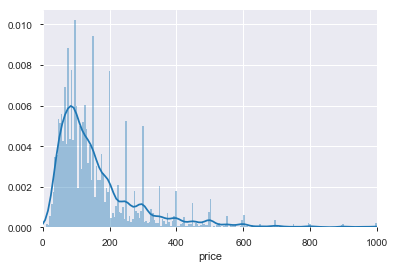

In [19]:
sns.distplot(listings.price, bins = 200)
plt.xlim(0, 1000)
plt.show()

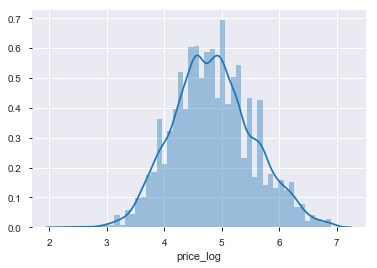

In [20]:
listings['price_log'] = np.log(listings.price)
sns.distplot(listings['price_log'])

## 1.4 Explore Occupancy

* No NA
* Very interesting visualization: shows polarization and high demand. Worth further investigation!

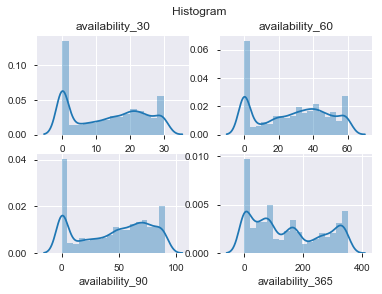

In [21]:
fig, axs = plt.subplots(ncols=2, nrows = 2)
fig.suptitle('Histogram')
sns.distplot(listings.availability_30, ax=axs[0,0]).set_title("availability_30")
sns.distplot(listings.availability_60, ax=axs[0,1]).set_title("availability_60")
sns.distplot(listings.availability_90, ax=axs[1,0])
sns.distplot(listings.availability_365, ax=axs[1,1])

## 1.5 Explore House Information Variables
#### Including: city,	state,	zipcode, property_type,	room_type,	accommodates,	bathrooms,	bedrooms,	beds,	bed_type, etc.

Text(0.5, 0, 'number of bedrooms')

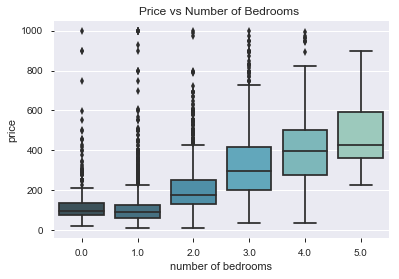

In [22]:
ax = sns.boxplot(x='bedrooms', y='price', data=listings[listings['bedrooms'] < 7], palette = "GnBu_d")
plt.title("Price vs Number of Bedrooms ")
plt.xlabel("number of bedrooms")

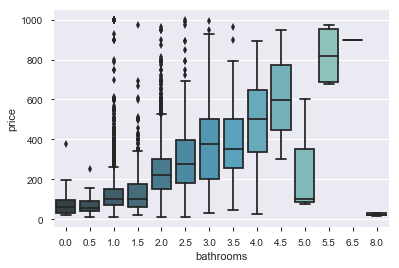

In [23]:
ax2 = sns.boxplot(x='bathrooms', y='price', data=listings, palette = "GnBu_d")

Text(0.5, 0, 'accommodates')

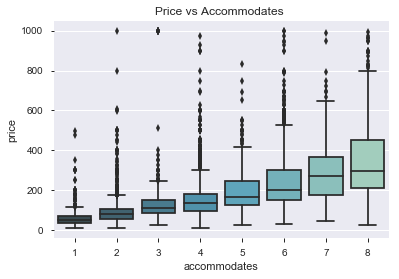

In [24]:
ax = sns.boxplot(x='accommodates', y='price', data=listings, palette = "GnBu_d")
plt.title("Price vs Accommodates ")
plt.xlabel("accommodates")

Text(0.5, 0, 'bathrooms/bedrooms ratio')

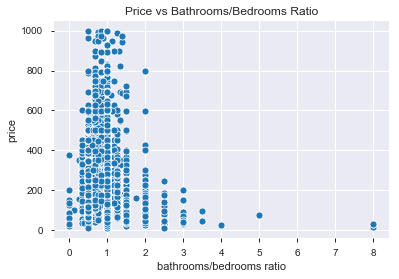

In [25]:
listings['bb_ratio'] = listings['bathrooms'] / listings['bedrooms']
listings['bb_ratio'] = [round(x, 2) if x < np.inf else 0 for x in listings['bb_ratio']]

ax3 = sns.scatterplot(x= 'bb_ratio', y='price', data = listings[listings['bedrooms']>0], palette = "green")
plt.title("Price vs Bathrooms/Bedrooms Ratio")
plt.xlabel("bathrooms/bedrooms ratio")

Text(0.5, 0, 'whether a property has a kitchen')

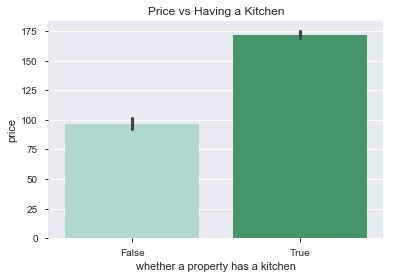

In [26]:
sns.barplot(x = 'kitchen', y = 'price', data = listings, palette = 'BuGn')
plt.title('Price vs Having a Kitchen')
plt.xlabel('whether a property has a kitchen')

Text(0.5, 0, 'room type')

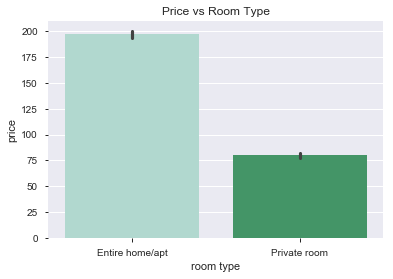

In [27]:
sns.barplot(x = 'room_type', y = 'price', data = listings[(listings['room_type']=='Entire home/apt') | (listings['room_type']=='Private room')], palette = 'BuGn')
plt.title("Price vs Room Type")
plt.xlabel("room type")

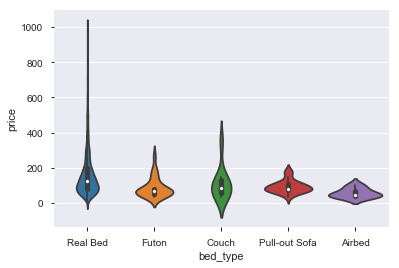

In [28]:
sns.violinplot(x='bed_type', y='price', data=listings)

/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Text(0.5, 0, 'property type')

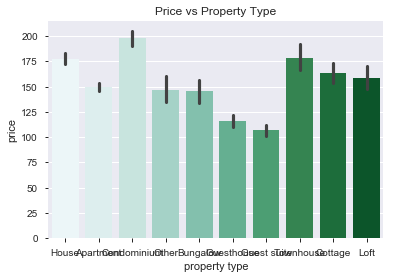

In [29]:
df = listings[['property_type_encode', 'price']]
encoding = dict(zip(['House', 'Apartment', 'Condominium', 'Other'], [1, 2, 3, 4]))
df['code'] = df['property_type_encode'].map(encoding)
df.sort_values(by = 'code', inplace = True)
chart = sns.barplot(x = 'property_type_encode', y = 'price', data = df, palette = 'BuGn')
#chart.set_xticklabels(chart.get_xticklabels(), rotation=40)
plt.title('Price vs Property Type')
plt.xlabel('property type')

## 1.6 Explore Geo Data

###### Map

In [30]:
import geopandas as gpd

# set the filepath and load in a shapefile
#fp = 'http://data.insideairbnb.com/united-states/ca/san-diego/2020-02-22/visualisations/neighbourhoods.geojson'
fp = '/Users/yuxinzhang/Personal Project/222/SanDiego_data/neighbourhoods.geojson'
map_df = gpd.read_file(fp)
# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
map_df.head()

,neighbourhood,neighbourhood_group,geometry
0,Amphitheater And Water Park,None,"(POLYGON ((-117.014515 32.587899, -117.014488 ..."
1,Bella Lago,None,"(POLYGON ((-116.941279 32.684306, -116.941278 ..."
2,Bonita Long Canyon,None,"(POLYGON ((-117.011489 32.663525, -117.011489 ..."
3,East Lake,None,"(POLYGON ((-116.993021 32.660396, -116.98164 3..."
4,Eastlake Trails,None,"(POLYGON ((-116.955116 32.641243, -116.95507 3..."


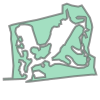

In [31]:
## Correct the corrupted mission bay geo polygon
from shapely.ops import unary_union

geo_lajolla = map_df[map_df.neighbourhood == 'La Jolla'].envelope.iloc[0]
geo_oldtown = map_df[map_df.neighbourhood == 'Old Town'].envelope.iloc[0]
geo_badmissionbay = map_df[map_df.neighbourhood == 'Mission Bay'].geometry.iloc[0]
geo_goodmissionbay = unary_union([geo_lajolla, geo_oldtown]).envelope.intersection(geo_badmissionbay)
map_df.loc[map_df.neighbourhood == 'Mission Bay', 'geometry'] = gpd.GeoDataFrame(
        geometry=[geo_goodmissionbay]).geometry.values
map_df['neighbourhood_coords'] = map_df['geometry'].centroid
map_df[map_df.neighbourhood == 'Mission Bay']['geometry'].iloc[0]

In [32]:
map_df[map_df.neighbourhood == 'Mission Bay'].head()

,neighbourhood,neighbourhood_group,geometry,neighbourhood_coords
70,Mission Bay,None,"(POLYGON ((-117.245845 32.7575, -117.245845 32...",POINT (-117.228535351795 32.7781562639459)


In [33]:
frame_geo = listings.groupby('neighbourhood_cleansed')['price'].mean().reset_index(name='average_price')
frame_geo['neighbourhood'] = frame_geo['neighbourhood_cleansed']

In [34]:
merged = pd.merge(map_df, frame_geo, on = 'neighbourhood', how="left")

merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
merged['coords'] = [coords[0] for coords in merged['coords']]

merged.sort_values(by = 'average_price', ascending = False)

,neighbourhood,neighbourhood_group,geometry,neighbourhood_coords,neighbourhood_cleansed,average_price,coords
2,Bonita Long Canyon,None,"(POLYGON ((-117.011489 32.663525, -117.011489 ...",POINT (-117.0003472210258 32.65688340776677),Bonita Long Canyon,312.500000,"(-117.00036417910891, 32.657165500000005)"
54,Horton Plaza,None,"(POLYGON ((-117.165801 32.712727, -117.165773 ...",POINT (-117.1643724508643 32.71432231023672),Horton Plaza,280.000000,"(-117.16435664983119, 32.714773)"
70,Mission Bay,None,"(POLYGON ((-117.245845 32.7575, -117.245845 32...",POINT (-117.228535351795 32.7781562639459),Mission Bay,272.746242,"(-117.23775086132926, 32.775686500000006)"
60,La Jolla,None,"(POLYGON ((-117.2823 32.839309, -117.282036 32...",POINT (-117.2554045537004 32.83641216190544),La Jolla,271.130288,"(-117.25770739116884, 32.838491000000005)"
43,Del Mar Heights,None,"(POLYGON ((-117.260955 32.9481, -117.260427 32...",POINT (-117.2507415950855 32.95095434324335),Del Mar Heights,262.956522,"(-117.25041491909226, 32.9562315)"
102,Torrey Pines,None,"(POLYGON ((-117.262145 32.939336, -117.261182 ...",POINT (-117.2426615823139 32.90127641600946),Torrey Pines,258.266667,"(-117.23936868831169, 32.904545)"
107,Wooded Area,None,"(POLYGON ((-117.258564 32.725764, -117.258545 ...",POINT (-117.2454001714056 32.70065599865705),Wooded Area,208.076923,"(-117.24725704802053, 32.6970635)"
80,Ocean Beach,None,"(POLYGON ((-117.257318 32.733364, -117.257309 ...",POINT (-117.2487799422715 32.74062534380749),Ocean Beach,197.385417,"(-117.25029396238097, 32.740700000000004)"
67,Midtown District,None,"(POLYGON ((-117.185636 32.728436, -117.185836 ...",POINT (-117.2031476636371 32.73644934868883),Midtown District,196.060606,"(-117.19767520742285, 32.73395)"
101,Tijuana River Valley,None,"(POLYGON ((-117.123064 32.543191, -117.122182 ...",POINT (-117.0935970304477 32.54609549013671),Tijuana River Valley,187.000000,"(-117.09169743419895, 32.547025500000004)"


In [35]:
#merged_ = merged
#merged_['average_price'].loc[merged_['neighbourhood'] == 'Mission Bay'] = 0

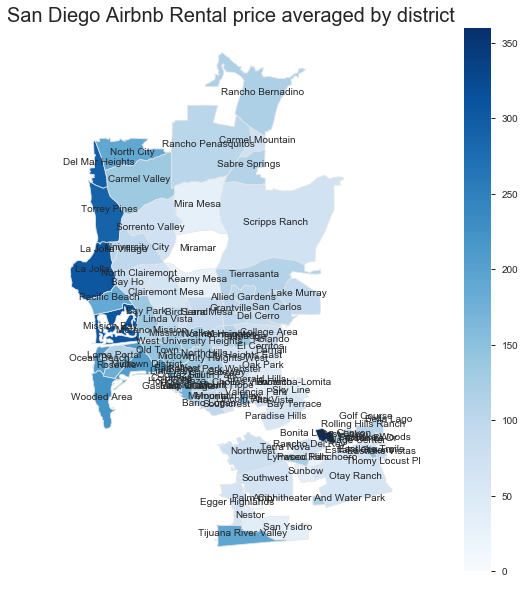

In [36]:
# set a variable that will call the column we want to visualise on the map
variable = 'average_price'
# set the range for the choropleth
vmin, vmax = 0, 360
# create figure and axes for Matplotlib

fig, ax = plt.subplots(1, figsize=(20, 10))
merged.plot(column='average_price', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.9')

for idx, row in merged.iterrows():
    plt.annotate(s=row['neighbourhood'], xy=row['coords'],
                 horizontalalignment='center')

#merged.apply(lambda x: ax.annotate(s=x.neighbourhood, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);

ax.axis('off')
# add a title
ax.set_title('San Diego Airbnb Rental price averaged by district', fontdict={'fontsize': '20', 'fontweight' : '3'})
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

In [37]:
frame_geo2 = listings.groupby('neighbourhood_cleansed')['id'].count().reset_index(name='id_count')
frame_geo2['neighbourhood'] = frame_geo2['neighbourhood_cleansed']

merged2 = pd.merge(map_df, frame_geo2, on = 'neighbourhood')

merged2['coords'] = merged2['geometry'].apply(lambda x: x.representative_point().coords[:])
merged2['coords'] = [coords[0] for coords in merged2['coords']]
merged2.sort_values('id_count', ascending= False)

,neighbourhood,neighbourhood_group,geometry,neighbourhood_coords,neighbourhood_cleansed,id_count,coords
64,Mission Bay,None,"(POLYGON ((-117.245845 32.7575, -117.245845 32...",POINT (-117.228535351795 32.7781562639459),Mission Bay,1131,"(-117.23775086132926, 32.775686500000006)"
76,Pacific Beach,None,"(POLYGON ((-117.262686 32.805324, -117.261027 ...",POINT (-117.2387304820325 32.8055037824339),Pacific Beach,777,"(-117.23892886538462, 32.807836)"
39,East Village,None,"(POLYGON ((-117.153788 32.696526, -117.160511 ...",POINT (-117.1528417407573 32.70810738012177),East Village,712,"(-117.15350365947012, 32.7093635)"
72,North Hills,None,"(POLYGON ((-117.147773 32.745145, -117.146418 ...",POINT (-117.1300586409253 32.74562127757226),North Hills,596,"(-117.13373431569428, 32.745881499999996)"
55,La Jolla,None,"(POLYGON ((-117.2823 32.839309, -117.282036 32...",POINT (-117.2554045537004 32.83641216190544),La Jolla,591,"(-117.25770739116884, 32.838491000000005)"
53,Midtown,None,"(POLYGON ((-117.182359 32.742454, -117.181273 ...",POINT (-117.1637579319884 32.74259868692185),Midtown,529,"(-117.1647458105443, 32.742859)"
74,Ocean Beach,None,"(POLYGON ((-117.257318 32.733364, -117.257309 ...",POINT (-117.2487799422715 32.74062534380749),Ocean Beach,384,"(-117.25029396238097, 32.740700000000004)"
16,Balboa Park,None,"(POLYGON ((-117.15949 32.736765, -117.158816 3...",POINT (-117.1434748449275 32.72764331767247),Balboa Park,279,"(-117.14445587152846, 32.728359999999995)"
61,Loma Portal,None,"(POLYGON ((-117.249118 32.743064, -117.242273 ...",POINT (-117.2294214306046 32.74683097392484),Loma Portal,274,"(-117.2335304241134, 32.744114499999995)"
60,Little Italy,None,"(POLYGON ((-117.174991 32.723209, -117.175009 ...",POINT (-117.1708764824191 32.72500423370977),Little Italy,213,"(-117.17023368253247, 32.7255905)"


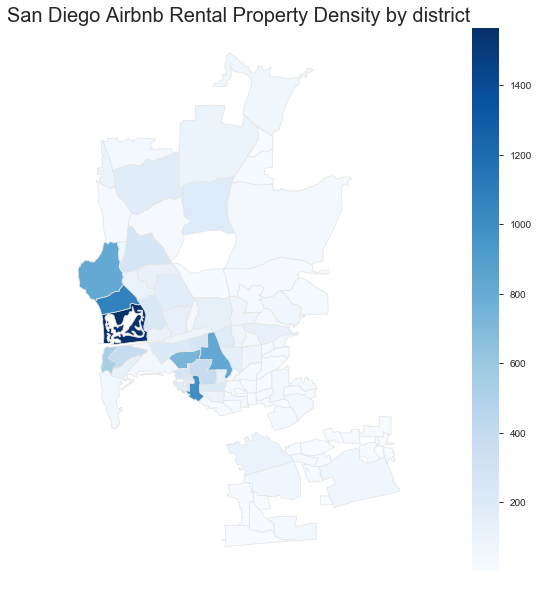

In [38]:
# set a variable that will call the column we want to visualise on the map
variable = 'id_count'
# set the range for the choropleth
vmin, vmax = 1, 1565
# create figure and axes for Matplotlib

fig, ax = plt.subplots(1, figsize=(20, 10))
merged2.plot(column='id_count', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.9')
#for idx, row in merged.iterrows():
#    plt.annotate(s=row['neighbourhood'], xy=row['coords'],
#                 horizontalalignment='center')
ax.axis('off')
# add a title
ax.set_title('San Diego Airbnb Rental Property Density by district', fontdict={'fontsize': '20', 'fontweight' : '3'})
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

In [39]:
from shapely.geometry import Point

geo = listings[["price", "latitude", "longitude"]]
geometry = [Point(xy) for xy in zip(geo['longitude'], geo['latitude'])]

crs = {'init': 'epsg:4326'}
geo_df = gpd.GeoDataFrame(geo,
                         crs = crs,
                         geometry = geometry)
geo_df.head()

/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,price,latitude,longitude,geometry
1,225.0,32.72839,-117.12824,POINT (-117.12824 32.72839)
2,225.0,32.80724,-117.25630,POINT (-117.2563 32.80724)
3,75.0,32.74202,-117.21870,POINT (-117.2187 32.74202)
4,74.0,32.73188,-117.11918,POINT (-117.11918 32.73188)
5,550.0,32.77784,-117.25355,POINT (-117.25355 32.77784)


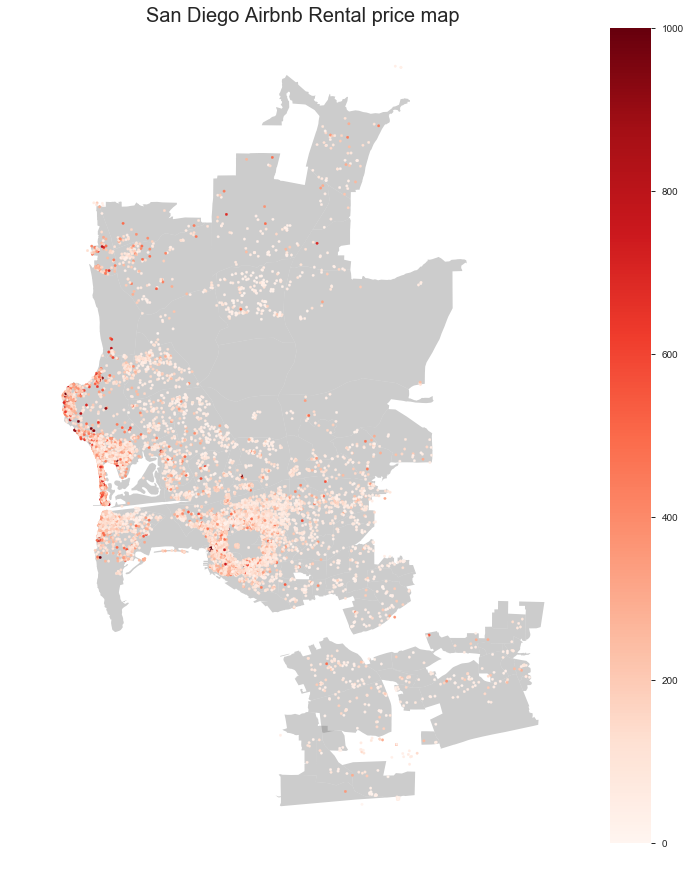

In [40]:
# set a variable that will call the column we want to visualise on the map
variable = 'average_price'
# set the range for the choropleth
vmin, vmax = 0, 1000
# create figure and axes for Matplotlib

fig, ax = plt.subplots(1, figsize=(15, 15))
map_df.plot(ax = ax, alpha = 0.4, color = "grey")

geo_df.plot(ax = ax, markersize = 6, column='price', cmap='Reds')
ax.axis('off')
# add a title
ax.set_title('San Diego Airbnb Rental price map', fontdict={'fontsize': '20', 'fontweight' : '3'})
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

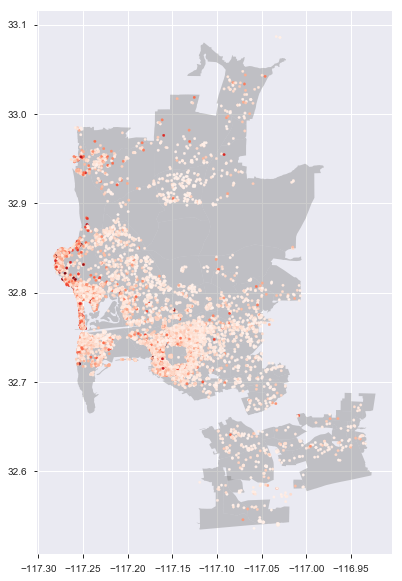

In [41]:
fig, ax = plt.subplots(figsize = (10,10))
map_df.plot(ax = ax, alpha = 0.4, color = "grey")

geo_df.plot(ax = ax, markersize = 6, column='price', cmap='Reds')

### Geo encoding

In [45]:
from math import radians

def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def manhattan_distance(lat1, lng1, lat2, lng2):
  return haversine_array(lat1,lng1,lat1,lng2) + haversine_array(lat1,lng1,lat2,lng1)

In [46]:
num = len(listings['longitude'])

balboa_park_lat = [32.7341 for _ in range(num)]
balboa_park_long = [-117.1446 for _ in range(num)]
listings['distance_to_balboa_park'] = round(manhattan_distance(listings['latitude'],listings['longitude'],balboa_park_lat,balboa_park_long), 2)

san_diego_zoo_lat = [32.7353 for _ in range(num)]
san_diego_zoo_long = [-117.1490 for _ in range(num)]
listings['distance_to_san_diego_zoo'] = manhattan_distance(listings['latitude'],listings['longitude'],san_diego_zoo_lat,san_diego_zoo_long)

national_monument_lat = [32.6735 for _ in range(num)]
national_monument_long = [-117.2425 for _ in range(num)]
listings['distance_to_national_monument'] = haversine_array(listings['latitude'],listings['longitude'],national_monument_lat,national_monument_long)

airport_lat = [32.733864 for _ in range(num)]
airport_long = [-117.193267 for _ in range(num)]
listings['distance_to_airport'] = haversine_array(listings['latitude'],listings['longitude'],airport_lat,airport_long)

seaworld_lat = [32.766976 for _ in range(num)]
seaworld_long = [-117.226428 for _ in range(num)]
listings['distance_to_seaworld'] = haversine_array(listings['latitude'],listings['longitude'],seaworld_lat,seaworld_long)

lajolla_lat = [32.856448 for _ in range(num)]
lajolla_long = [-117.257248 for _ in range(num)]
listings['distance_to_lajolla'] = haversine_array(listings['latitude'],listings['longitude'],lajolla_lat,lajolla_long)

torreybeach_lat = [32.936347 for _ in range(num)]
torreybeach_long = [-117.261442 for _ in range(num)]
listings['distance_to_torreybeach'] = haversine_array(listings['latitude'],listings['longitude'],torreybeach_lat,torreybeach_long)

sunsetcliff_lat = [32.718217 for _ in range(num)]
sunsetcliff_long = [-117.254865 for _ in range(num)]
listings['distance_to_sunsetcliff'] = haversine_array(listings['latitude'],listings['longitude'],sunsetcliff_lat,sunsetcliff_long)

convention_center_lat = [32.707564 for _ in range(num)]
convention_center_long = [-117.162509 for _ in range(num)]
listings['distance_to_convention_center'] = haversine_array(listings['latitude'],listings['longitude'],convention_center_lat,convention_center_long)



## 1.8 Explore Listing Descriptive Variables 
#### Including: name,	summary,	space,	description,	experiences_offered,	neighborhood_overview,	notes,	transit,	access,	interaction,	house_rules,	thumbnail_url,	medium_url,	picture_url,	xl_picture_url

* No NA in name
* Very few NA in summary, description <2%
* High percent of NA in other variables
* Exclude experiences_offered (constant), and all urls

In [47]:
print("# NA in name: " + str(listings.name.isnull().sum()))
print("# NA in summary: " + str(round(listings.summary.isnull().sum()/listings.shape[0], 2)))
print("# NA in description: " + str(round(listings.description.isnull().sum()/listings.shape[0], 2)))
print("# NA in neighborhood_overview: " + str(round(listings.neighborhood_overview.isnull().sum()/listings.shape[0], 2)))
print("# NA in notes: " + str(round(listings.notes.isnull().sum()/listings.shape[0], 2)))
print("# NA in transit: " + str(round(listings.transit.isnull().sum()/listings.shape[0], 2)))
print("# NA in access: " + str(round(listings.access.isnull().sum()/listings.shape[0], 2)))
print("# NA in interaction: " + str(round(listings.interaction.isnull().sum()/listings.shape[0], 2)))
print("# NA in house_rules: " + str(round(listings.house_rules.isnull().sum()/listings.shape[0], 2)))

# NA in name: 0
# NA in summary: 0.04
# NA in description: 0.02
# NA in neighborhood_overview: 0.26
# NA in notes: 0.42
# NA in transit: 0.33
# NA in access: 0.35
# NA in interaction: 0.3
# NA in house_rules: 0.25


In [48]:
listings = listings.drop(['experiences_offered','thumbnail_url','medium_url','picture_url','xl_picture_url'], axis=1)
print("Number of columns: " + str(listings.shape[1]))

Number of columns: 133


### Basic Features
Don't think we need this many variables. Maybe 
* combine some together OR delete some
* try different normalization rather than divide by length
* change to 1/0
* log transform

###### Length

In [49]:
listings['name_len'] = listings.name.str.len()

listings['summary_len'] = listings.summary.str.len()
listings.loc[listings['summary_len'].isnull(), 'summary_len'] = 0

listings['description_len'] = listings.description.str.len()
listings.loc[listings['description_len'].isnull(), 'description_len'] = 0

listings['neighborhood_overview_len'] = listings.neighborhood_overview.str.len()
listings.loc[listings['neighborhood_overview_len'].isnull(), 'neighborhood_overview_len'] = 0

listings['notes_len'] = listings.notes.str.len()
listings.loc[listings['notes_len'].isnull(), 'notes_len'] = 0

listings['transit_len'] = listings.transit.str.len()
listings.loc[listings['transit_len'].isnull(), 'transit_len'] = 0

listings['access_len'] = listings.access.str.len()
listings.loc[listings['access_len'].isnull(), 'access_len'] = 0

listings['interaction_len'] = listings.interaction.str.len()
listings.loc[listings['interaction_len'].isnull(), 'interaction_len'] = 0

listings['house_rules_len'] = listings.house_rules.str.len()
listings.loc[listings['house_rules_len'].isnull(), 'house_rules_len'] = 0

listings[['neighborhood_overview_len', 'neighborhood_overview']].head()

,neighborhood_overview_len,neighborhood_overview
1,124.0,South Park is a charming community and our nei...
2,0.0,NaN
3,281.0,"This neighborhood is an expensive, high-end Po..."
4,314.0,"We love our eclectic neighborhood, with a smal..."
5,173.0,Mission Beach is a lively fun area filled with...


###### #special characters / length

In [50]:
listings['name_spec'] = [len(re.sub('[A-Za-z0-9\s]+', '', str(x))) for x in listings['name']] / listings['name_len']
listings['summary_spec'] = [len(re.sub('[A-Za-z0-9\s]+', '', str(x))) for x in listings['summary']] / listings['summary_len']
listings['description_spec'] = [len(re.sub('[A-Za-z0-9\s]+', '', str(x))) for x in listings['description']] / listings['description_len']
listings['neighborhood_overview_spec'] = [len(re.sub('[A-Za-z0-9\s]+', '', str(x))) for x in listings['neighborhood_overview']] / listings['neighborhood_overview_len']
listings['notes_spec'] = [len(re.sub('[A-Za-z0-9\s]+', '', str(x))) for x in listings['notes']] / listings['notes_len']
listings['transit_spec'] = [len(re.sub('[A-Za-z0-9\s]+', '', str(x))) for x in listings['transit']] / listings['transit_len']
listings['access_spec'] = [len(re.sub('[A-Za-z0-9\s]+', '', str(x))) for x in listings['access']] / listings['access_len']
listings['interaction_spec'] = [len(re.sub('[A-Za-z0-9\s]+', '', str(x))) for x in listings['interaction']] / listings['interaction_len']
listings['house_rules_spec'] = [len(re.sub('[A-Za-z0-9\s]+', '', str(x))) for x in listings['house_rules']] / listings['house_rules_len']

listings[['neighborhood_overview_spec', 'neighborhood_overview']].head()

,neighborhood_overview_spec,neighborhood_overview
1,0.024194,South Park is a charming community and our nei...
2,NaN,NaN
3,0.039146,"This neighborhood is an expensive, high-end Po..."
4,0.035032,"We love our eclectic neighborhood, with a smal..."
5,0.023121,Mission Beach is a lively fun area filled with...


Remove special characters

In [51]:
listings['name'] = [re.sub('[^A-Za-z0-9]+', ' ', str(x)) for x in listings['name']]
listings['summary'] = [re.sub('[^A-Za-z0-9]+', ' ', str(x)) for x in listings['summary']]
listings['description'] = [re.sub('[^A-Za-z0-9]+', ' ', str(x)) for x in listings['description']]
listings['neighborhood_overview'] = [re.sub('[^A-Za-z0-9]+', ' ', str(x)) for x in listings['neighborhood_overview']]
listings['notes'] = [re.sub('[^A-Za-z0-9]+', ' ', str(x)) for x in listings['notes']]
listings['transit'] = [re.sub('[^A-Za-z0-9]+', ' ', str(x)) for x in listings['transit']]
listings['access'] = [re.sub('[^A-Za-z0-9]+', ' ', str(x)) for x in listings['access']]
listings['interaction'] = [re.sub('[^A-Za-z0-9]+', ' ', str(x)) for x in listings['interaction']]
listings['house_rules'] = [re.sub('[^A-Za-z0-9]+', ' ', str(x)) for x in listings['house_rules']]

listings.name[10]

'Winter Rates 30 Seconds from your Bed 2 the Beach '

###### #Numbers

In [52]:
listings['name_num'] = listings['name'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
listings['summary_num'] = listings['summary'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
listings['description_num'] = listings['description'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
listings['neighborhood_overview_num'] = listings['neighborhood_overview'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
listings['notes_num'] = listings['notes'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
listings['transit_num'] = listings['transit'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
listings['access_num'] = listings['access'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
listings['interaction_num'] = listings['interaction'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
listings['house_rules_num'] = listings['house_rules'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

listings[['name_num','name']].head(10)

,name_num,name
1,0,Juniper Zen Palace SD s Best Hood
2,1,Great home 10 min walk to Beach
3,0,Point Loma Liberty Station NTC
4,0,Art Studio Retreat Rustic Cabin
5,0,Surf Rider Ocean Front Condo in Mission Beach
6,0,La Jolla Peaceful Sitting Room Breakfast
7,0,charming colorful close to beach
8,0,Pacific Beach Cozy Private Unit Bikes Included
9,0,Canyon apartment hideaway
10,2,Winter Rates 30 Seconds from your Bed 2 the Be...


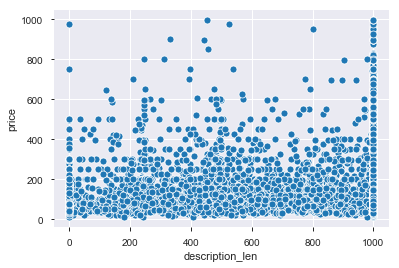

In [53]:
sns.scatterplot(y = 'price', x = 'description_len', data = listings)

### TF-IDF
* High dimension, then what? PCA?
* NA: remove NA first and then add 0?

* Code: https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.XlvpGJNKhQI
https://www.bogotobogo.com/python/NLTK/tf_idf_with_scikit-learn_NLTK.php

In [54]:
## combine
listings['descriptC'] = (listings['name'] + " " + listings['description'] + " " +
                                listings['neighborhood_overview'] + " " + listings['notes'] + " " +
                                listings['transit'] + " " + listings['access'] + " " +
                                listings['interaction'] + " " + listings['house_rules'])
listings['descriptC'] = [re.sub('nan ', '', str(x)) for x in listings['descriptC']]

In [55]:
text = ''
for i in listings.descriptC:
    text = text + str(i)

In [56]:
text = re.sub("San Diego", "", text)
text = re.sub("san diego", "", text)

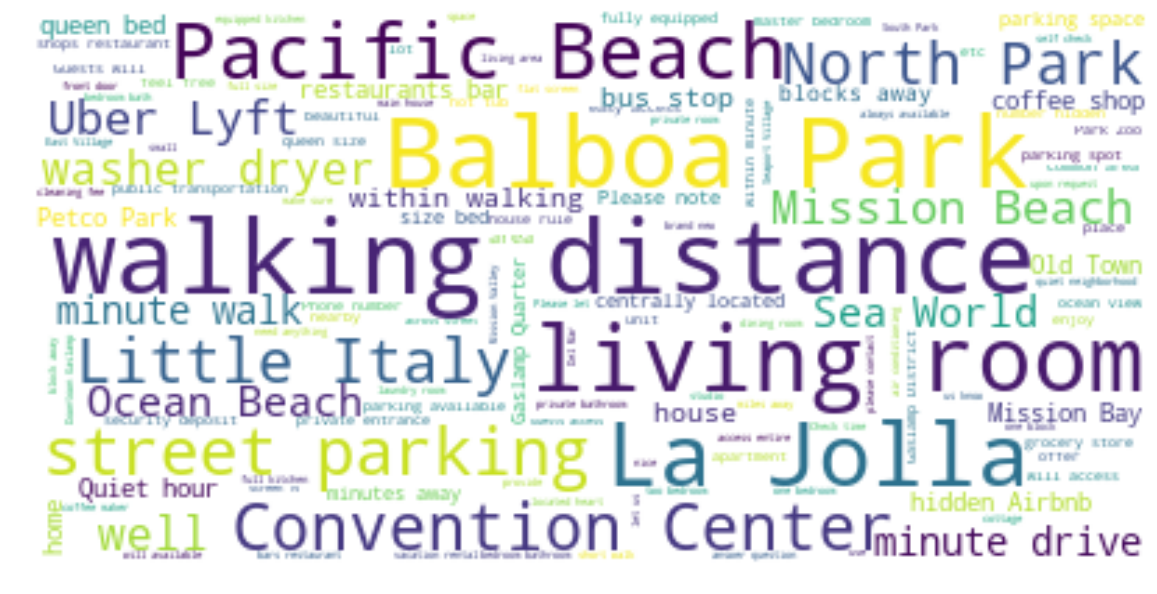

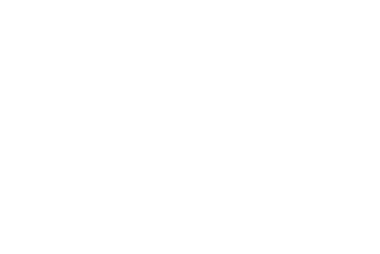

In [57]:
from wordcloud import WordCloud, STOPWORDS 

stopwds = set(STOPWORDS)
stopwds.add("said")

wc = WordCloud(background_color="white", max_words=5000, #mask=alice_mask,
               stopwords=stopwds, contour_width=3, contour_color='steelblue')

# generate word cloud
wc.generate(text)

# show
plt.figure(figsize = (20,20))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
#plt.imshow(alice_mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()

In [58]:
## remove numbers
regex_pat = re.compile("[^a-zA-Z]+")
listings.descriptC = listings.descriptC.str.replace(regex_pat, ' ')
## lower-case
listings['descriptC'] = listings['descriptC'].apply(lambda x: " ".join(x.lower() for x in x.split()))
## remove stop words
nltk.download('stopwords')
stop = stopwords.words('english')
listings['descriptC'] = listings['descriptC'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
## stem
st = PorterStemmer()
listings['descriptC'] = listings['descriptC'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

listings.descriptC.head(10)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yuxinzhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1     junip zen palac sd best hood walk everi san di...
2     great home min walk beach bedroom full bathroo...
3     point loma liberti station ntc stay spanish st...
4     art studio retreat rustic cabin love explor wo...
5     surf rider ocean front condo mission beach sur...
6     la jolla peac sit room breakfast peac one two ...
7     charm color close beach modern cozi artsi euro...
8     pacif beach cozi privat unit bike includ wonde...
9     canyon apart hideaway recent renov apart look ...
10    winter rate second bed beach nt guest winter s...
Name: descriptC, dtype: object

In [59]:
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
    return stems

In [60]:
nltk.download('punkt')
tfidf_vectorizer=TfidfVectorizer(use_idf=True, tokenizer=tokenize, stop_words='english')

tfidf_descriptC=tfidf_vectorizer.fit_transform(listings.descriptC)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yuxinzhang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth'

In [61]:
descriptC_sdf = pd.SparseDataFrame(tfidf_vectorizer.fit_transform(listings['descriptC']),
                         columns = tfidf_vectorizer.get_feature_names(), 
                         default_fill_value = 0)
descriptC_sdf.shape

(10042, 15612)

In [62]:
## svd to reduce dimension
svd = TruncatedSVD(1)
descriptC_svd = svd.fit_transform(descriptC_sdf)
descriptC_svd.shape

(10042, 1)

In [63]:
listings['svd'] = descriptC_svd

/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0, 'whether host is superhost')

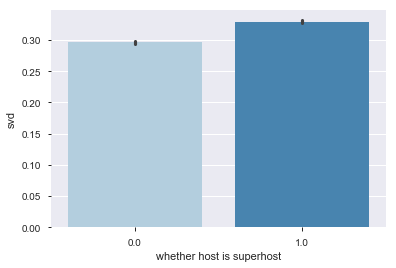

In [64]:
sns.barplot(x = 'host_is_superhost', y = 'svd', data = listings, palette = 'Blues')
plt.xlabel("whether host is superhost")

In [65]:
del descriptC_sdf

### Sentiment Analysis
* Polarity: [-1.0, 1.0]. 
* Subjectivity: [0.0, 1.0], where 0.0 is very objective and 1.0 is very subjective.

In [66]:
listings['descriptC_p'] = listings['descriptC'].apply(lambda x: TextBlob(x).sentiment[0])
listings['descriptC_s'] = listings['descriptC'].apply(lambda x: TextBlob(x).sentiment[1])

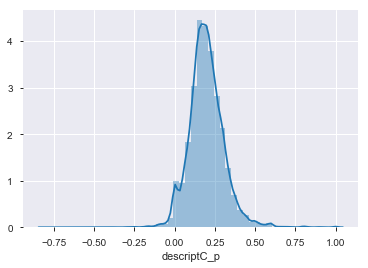

In [67]:
sns.distplot(listings['descriptC_p'])

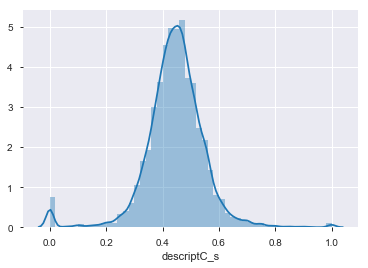

In [68]:
sns.distplot(listings['descriptC_s'])

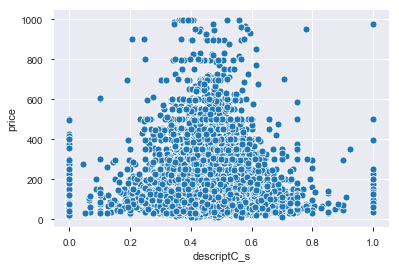

In [69]:
sns.scatterplot(x = "descriptC_s", y = "price", data = listings)

In [70]:
listings['descriptC'].loc[listings['descriptC_p'] < -0.5]

12591    joker choic privat room list one privat room b...
Name: descriptC, dtype: object

In [71]:
listings['house_rules_p'] = listings['house_rules'].apply(lambda x: TextBlob(x).sentiment[0])

## 1.9 Explore Host Variables
#### Including: host_url,	host_name,	host_since,	host_location,	host_about,	host_response_time,	host_response_rate,	host_acceptance_rate,	host_is_superhost	, etc.

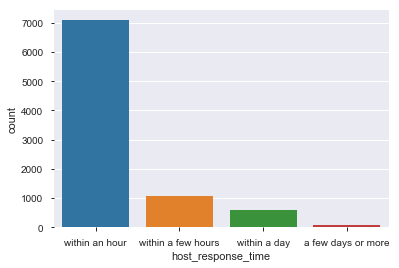

In [72]:
sns.countplot(listings['host_response_time'])

/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


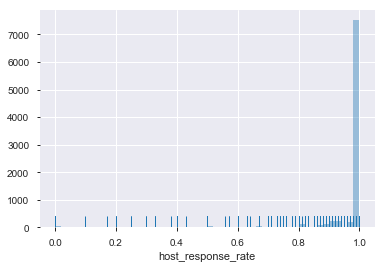

In [73]:
sns.distplot(listings['host_response_rate'], rug = True, kde = False)

Text(0.5, 6.799999999999979, 'whether host is superhost')

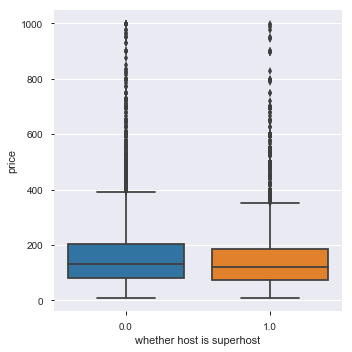

In [74]:
listings['host_is_superhost'] = listings['host_is_superhost'].astype('category')
sns.catplot(x = 'host_is_superhost', y = 'price', data = listings, kind = 'box')
plt.xlabel("whether host is superhost")

/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


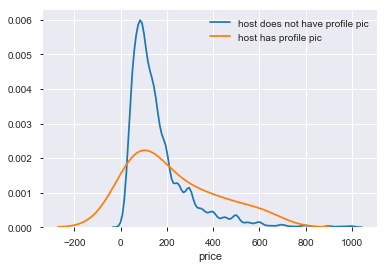

In [75]:
sns.distplot(listings[listings['host_has_profile_pic'] == 1]['price'], hist = False, label = 'host does not have profile pic')
sns.distplot(listings[listings['host_has_profile_pic'] == 0]['price'], hist = False, label = 'host has profile pic')

[[Text(0, 0, 'False'), Text(0, 0, 'True')]]

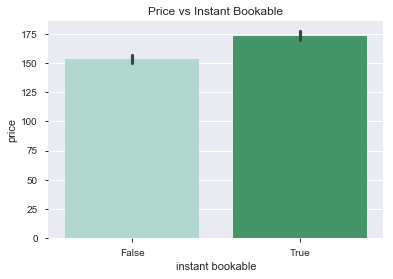

In [76]:
fig = sns.barplot(x = 'instant_bookable', y = 'price', data = listings, palette = "BuGn")
plt.title('Price vs Instant Bookable')
plt.xlabel('instant bookable')
fig.set(xticklabels=['False', 'True'])

/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Text(0.5, 0, 'cancellation policy')

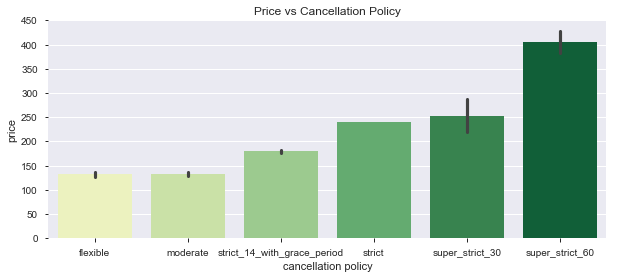

In [77]:
df = listings[['cancellation_policy', 'price']]
encoding_dict = dict(zip(['flexible', 'moderate', 'strict_14_with_grace_period', 'strict', 'super_strict_30', 'super_strict_60'], [1, 2, 3, 4, 5, 6]))
df['code'] = df['cancellation_policy'].map(encoding_dict)
df.sort_values(by = 'code', inplace = True)
plt.figure(figsize=(10,4))
fig = sns.barplot(x = 'cancellation_policy', y='price', data = df, palette = "YlGn")
plt.title("Price vs Cancellation Policy")
plt.xlabel("cancellation policy")

## 1.10 Explore Review Variables
#### Listings Including: number_of_reviews,	number_of_reviews_ltm,	first_review,	last_review,	review_scores_rating,	review_scores_accuracy, etc.

#### Reviews Including: comments

In [78]:
#base_data_url="http://data.insideairbnb.com/united-states/ca/san-diego/2019-11-21/data/"
#reviews = pd.read_csv(base_data_url + "reviews.csv.gz", compression='gzip', low_memory=False)
reviews = pd.read_csv(path + "reviews.csv.gz", compression = "gzip", low_memory = False)
reviews = reviews.iloc[:,[0,5]]
reviews.head()

,listing_id,comments
0,8488,Love these guys! So cool and fun and accommoda...
1,8488,We stayed at Helene's place while in town for ...
2,8488,very nice stay in this cute house in South Par...
3,8488,Juniper Zen Palace was exactly what I was sear...
4,8488,Helene & Preston were awesome! We traveled ou...


###### Listings

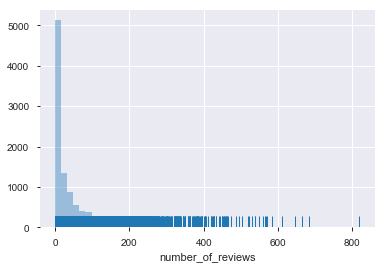

In [79]:
sns.distplot(listings['number_of_reviews'], kde = False, rug = True)

Text(0.5, 0, 'logarithmic number of reviews')

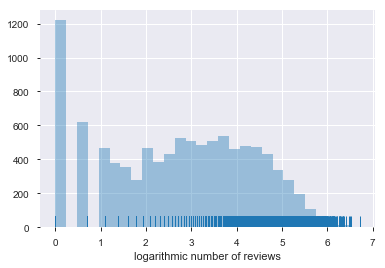

In [80]:
sns.distplot(np.log(listings['number_of_reviews']+1), kde = False, rug = True)
plt.xlabel('logarithmic number of reviews')

In [81]:
listings['number_of_reviews_log'] = np.log(listings['number_of_reviews'] + 1)

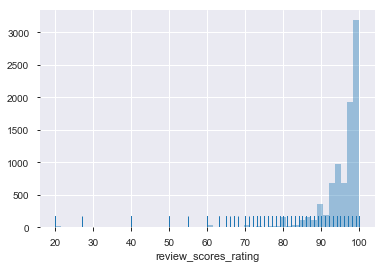

In [82]:
sns.distplot(listings[listings['review_scores_rating'].notnull()]['review_scores_rating'], kde = False, rug = True)


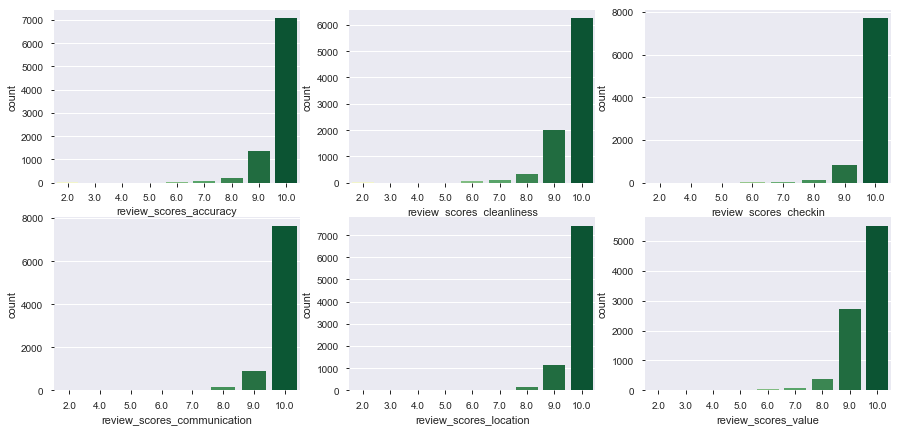

In [83]:
fig, axes = plt.subplots(ncols=3, nrows = 2, figsize=(15, 7))
sns.countplot(x="review_scores_accuracy", data = listings, ax=axes[0, 0], palette = "YlGn")
sns.countplot(x="review_scores_cleanliness", data = listings, ax=axes[0, 1], palette = "YlGn")
sns.countplot(x="review_scores_checkin", data = listings, ax=axes[0, 2], palette = "YlGn")
sns.countplot(x="review_scores_communication", data = listings, ax=axes[1, 0], palette = "YlGn")
sns.countplot(x="review_scores_location", data = listings, ax=axes[1, 1], palette = "YlGn")
sns.countplot(x="review_scores_value", data = listings, ax=axes[1, 2], palette = "YlGn")

###### Reviews 

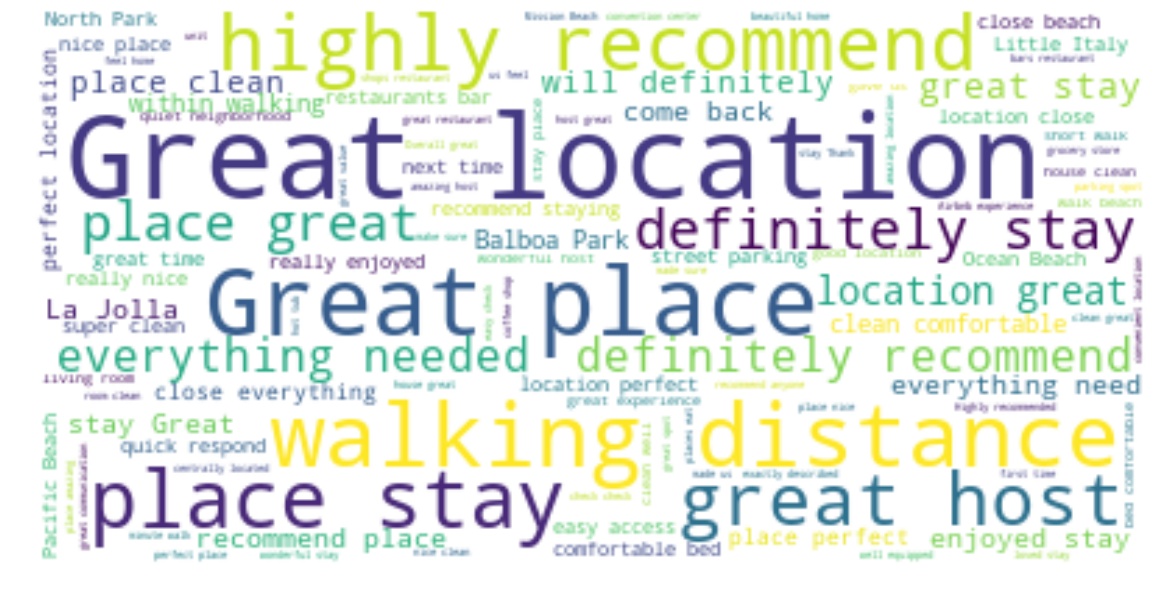

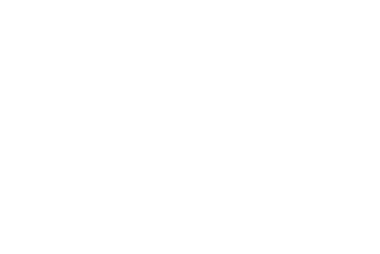

In [84]:
##### BASIC FEATURES #####
reviews['review_len'] = reviews.comments.str.len()

reviews['review_spec'] = [len(re.sub('[A-Za-z0-9\s]+', '', str(x))) for x in reviews['comments']] / reviews['review_len']
reviews['comments'] = [re.sub('[^A-Za-z0-9]+', ' ', str(x)) for x in reviews['comments']]

reviews['review_num'] = reviews['comments'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

##### WORDCLOUD #####
text = ''
for i in reviews.comments:
    text = text + str(i)

text = re.sub("San Diego", "", text)
text = re.sub("san diego", "", text)
    
from wordcloud import WordCloud, STOPWORDS 
stopwds = set(STOPWORDS)
stopwds.add("said")

wc = WordCloud(background_color="white", max_words=5000, 
               stopwords=stopwds, contour_width=3, contour_color='steelblue')

wc.generate(text)

# show
plt.figure(figsize = (20,20))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.axis("off")
plt.show()

del wc
del text

In [85]:
##### TF-IDF #####
regex_pat = re.compile("[^a-zA-Z]+")
reviews['comments'] = reviews.comments.str.replace(regex_pat, ' ')
reviews['comments'] = reviews['comments'].apply(lambda x: " ".join(x.lower() for x in x.split()))

nltk.download('stopwords')
stop = stopwords.words('english')
reviews['comments'] = reviews['comments'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

st = PorterStemmer()
reviews['comments'] = reviews['comments'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

nltk.download('punkt')
tfidf_vectorizer=TfidfVectorizer(use_idf=True, tokenizer=tokenize, stop_words='english', max_features=100)

comments_sdf = pd.SparseDataFrame(tfidf_vectorizer.fit_transform(reviews['comments']),
                         columns = tfidf_vectorizer.get_feature_names(), 
                         default_fill_value = 0)
## svd
svd = TruncatedSVD(1)
comments_svd = svd.fit_transform(comments_sdf)
reviews['svd_R'] = comments_svd

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yuxinzhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yuxinzhang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', '

In [86]:
reviews['comments'] = reviews['comments'].astype(str)

##### SENTIMENT ANALYSIS #####
reviews['review_p'] = reviews['comments'].apply(lambda x: TextBlob(x).sentiment[0])
reviews['review_s'] = reviews['comments'].apply(lambda x: TextBlob(x).sentiment[1])

reviews.describe()

,listing_id,review_len,review_spec,review_num,svd_R,review_p,review_s
count,4.988490e+05,498560.000000,498560.000000,498849.000000,498849.000000,498849.000000,498849.000000
mean,1.567008e+07,262.059385,0.037696,0.288937,0.343571,0.420991,0.575538
std,9.904843e+06,262.302160,0.077994,0.838701,0.116278,0.243961,0.228373
min,8.488000e+03,1.000000,0.000000,0.000000,0.000000,-1.000000,0.000000
25%,7.070503e+06,94.000000,0.021667,0.000000,0.277274,0.272222,0.485714
50%,1.541034e+07,191.000000,0.028051,0.000000,0.353426,0.416667,0.604762
75%,2.283435e+07,341.000000,0.037037,0.000000,0.423588,0.583333,0.733333
max,4.023440e+07,5535.000000,1.000000,41.000000,0.698015,1.000000,1.000000


/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


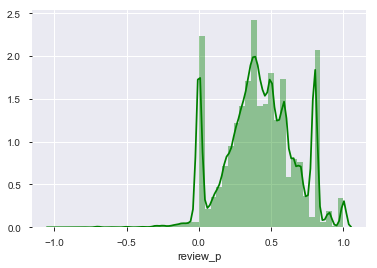

In [87]:
sns.distplot(reviews['review_p'], color='g')

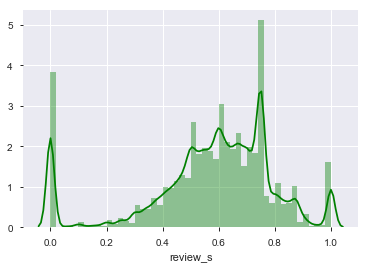

In [88]:
sns.distplot(reviews['review_s'], color='g')

In [89]:
reviews.head()

,listing_id,comments,review_len,review_spec,review_num,svd_R,review_p,review_s
0,8488,love guy cool fun accommod feel lucki met grea...,122.0,0.040984,0,0.361400,0.591667,0.616667
1,8488,stay helen place town confer convent center en...,523.0,0.030593,1,0.395492,0.069048,0.428571
2,8488,nice stay cute hous south park pretti decor be...,241.0,0.041494,0,0.353353,0.340000,0.606667
3,8488,junip zen palac exactli search went look tempo...,527.0,0.013283,0,0.344470,0.140000,0.350000
4,8488,helen preston awesom travel southern californi...,507.0,0.021696,0,0.450436,0.409524,0.526190


###### Merge Reviews with Listings

In [90]:
reviews = reviews.groupby('listing_id')['review_len', 'review_spec', 'review_num',
                                        'svd_R', 'review_p', 'review_s'].mean().reset_index()
reviews.rename(columns = {'listing_id':'id'}, inplace = True)

listings = pd.merge(listings, reviews, on = 'id', how = 'left')
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,neighborhood_overview,notes,transit,access,interaction,house_rules,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,calendar_updated_trans,a few days or more,within a day,within a few hours,within an hour,property_type_encode,Apartment,Bungalow,Condominium,Cottage,Guest suite,Guesthouse,House,Loft,Other,Townhouse,Entire home/apt,Hotel room,Private room,Shared room,kitchen,price_log,bb_ratio,distance_to_balboa_park,distance_to_san_diego_zoo,distance_to_national_monument,distance_to_airport,distance_to_seaworld,distance_to_lajolla,distance_to_torreybeach,distance_to_sunsetcliff,distance_to_convention_center,name_len,summary_len,description_len,neighborhood_overview_len,notes_len,transit_len,access_len,interaction_len,house_rules_len,name_spec,summary_spec,description_spec,neighborhood_overview_spec,notes_spec,transit_spec,access_spec,interaction_spec,house_rules_spec,name_num,summary_num,description_num,neighborhood_overview_num,notes_num,transit_num,access_num,interaction_num,house_rules_num,descriptC,svd,descriptC_p,descriptC_s,house_rules_p,number_of_reviews_log,review_len,review_spec,review_num,svd_R,review_p,review_s
0,8488,https://www.airbnb.com/rooms/8488,20191121092222,2019-11-21,Juniper Zen Palace SD s Best Hood,Walk every where in San Diegos most charming a...,Private craftsman home in the heart of Histori...,Walk every where in San Diegos most charming a...,South Park is a charming community and our nei...,we have no cable tv just streaming services we...,bus route to downtown is 1 2 block away,backyard,nan,Check in time is 3PM We are fun easygoing peo...,25186,https://www.airbnb.com/users/show/25186,Helene,2009-07-10,"Los Angeles, California, United States",HI! I am a photographer on tour. I have severa...,within an hour,1.0,NaN,0.0,https://a0.muscache.com/im/pictures/user/b83cc...,https://a0.muscache.com/im/pictures/user/b83cc...,Burlingame,4.0,4.0,"['email', 'phone', 'facebook', 'reviews', 'off...",1.0,1.0,"San Diego, CA, United States",South Park,South Park,NaN,San Diego,CA,92104,San Diego,"San Diego, CA",US,United States,32.72839,-117.12824,t,House,Entire home/apt,5,2.0,3.0,3.0,Real Bed,"{TV,Internet,Wifi,Kitchen,""Free parking on pre...",NaN,225.0,NaN,NaN,$300.00,$175.00,4,$50.00,3,1125,3,3,1125,1125,3.0,1125.0,5 weeks ago,t,6,20,42,218,2019-11-21,40,0,2010-10-13,2016-03-24,97.0,9.0,9.0,10.0,10.0,10.0,9.0,f,NaN,"{""SAN DIEGO"","" SAN DIEGO TOURISM MARKETING DIS...",0,0,strict_14_with_grace_per

# 2. Calender Data Preparation

In [91]:
#base_data_url="http://data.insideairbnb.com/united-states/ca/san-diego/2019-11-21/data/"
#calendar=pd.read_csv(base_data_url + "calendar.csv.gz", compression='gzip')

calendar=pd.read_csv(path + 'calendar.csv')

In [92]:
calendar['price'] = calendar['price'].replace('[\$,]', '', regex=True).astype(float)
calendar['adjusted_price'] = calendar['adjusted_price'].replace('[\$,]', '', regex=True).astype(float)
calendar['date'] = calendar['date'].astype('datetime64')
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,5570,2019-11-21,f,2050.0,2050.0,3,365
1,5570,2019-11-22,f,2050.0,2050.0,3,365
2,5570,2019-11-23,f,2050.0,2050.0,3,365
3,5570,2019-11-24,f,2050.0,2050.0,3,365
4,5570,2019-11-25,f,2050.0,2050.0,3,365


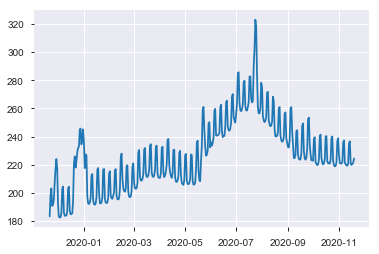

In [93]:
neighborhood_from_listings = listings[['id', 'neighbourhood_cleansed']]
calendar_with_neighbor = calendar.merge(neighborhood_from_listings,how='left', left_on='listing_id', right_on='id').drop(['id','listing_id'],axis=1)
price_vs_date = calendar_with_neighbor.groupby(['date']).mean()
plt.plot(price_vs_date.index,price_vs_date.price)

In [94]:
calendar_with_neighbor.groupby(['neighbourhood_cleansed','date']).mean()

price  adjusted_price  minimum_nights  \
neighbourhood_cleansed date                                                     
Allied Gardens         2019-11-21  108.500000      106.888889        8.555556   
                       2019-11-22  110.166667      108.555556        8.611111   
                       2019-11-23  111.000000      109.388889        8.611111   
                       2019-11-24  110.666667      109.055556        8.611111   
                       2019-11-25  110.666667      109.055556        8.555556   
                       2019-11-26  108.444444      106.833333        8.666667   
                       2019-11-27  109.500000      108.055556        7.333333   
                       2019-11-28  110.611111      109.166667        8.611111   
                       2019-11-29  110.888889      109.444444        8.666667   
                       2019-11-30  110.888889      109.444444        8.666667   
                       2019-12-01  108.333333      106.888889        8.666667   
                       2019-12-02  107.722222      106.277778        8.611111   
                       2019-12-03  106.333333      104.888889        8.611111   
                       2019-12-04  106.333333      104.888889        8.611111   
                       2019-12-05  106.333333      104.888889        8.500000   
                       2019-12-06  108.611111      107.166667        8.555556   
                       2019-12-07  108.611111      107.166667        8.555556   
                       2019-12-08  108.611111      107.166667        8.555556   
                       2019-12-09  106.333333      104.888889        8.611111   
                       2019-12-10  106.333333      104.888889        8.611111   
                       2019-12-11  106.333333      104.888889        8.611111   
                       2019-12-12  106.333333      104.888889        8.500000   
                       2019-12-13  108.333333      106.888889        8.555556   
                       2019-12-14  108.333333      106.888889        8.555556   
                       2019-12-15  108.611111      107.166667        8.555556   
                       2019-12-16  107.833333      106.388889        8.888889   
                       2019-12-17  106.777778      105.333333        8.888889   
                       2019-12-18  106.611111      105.166667        8.888889   
                       2019-12-19  110.500000      109.055556        7.611111   
                       2019-12-20  118.111111      118.111111        7.722222   
                       2019-12-21  118.333333      118.333333        7.722222   
                       2019-12-22  119.777778      119.777778        7.722222   
                       2019-12-23  120.111111      120.111111        7.777778   
                       2019-12-24  124.222222      124.222222        7.777778   
                       2019-12-25  124.388889      124.388889        7.777778   
                       2019-12-26  121.444444      121.444444        7.666667   
                       2019-12-27  123.111111      123.111111        7.722222   
                       2019-12-28  120.111111      120.111111        7.722222   
                       2019-12-29  119.888889      119.888889        7.722222   
                       2019-12-30  119.611111      119.611111        7.777778   
                       2019-12-31  119.555556      119.555556        7.777778   
                       2020-01-01  119.055556      119.055556        7.777778   
                       2020-01-02  118.222222      118.222222        7.666667   
                       2020-01-03  113.444444      113.444444        8.833333   
                       2020-01-04  113.388889      113.388889        8.833333   
                       2020-01-05  112.277778      112.277778        8.833333   
                       2020-01-06  109.722222      109.722222        8.611111   
                       2020-01-07  109.611111      109.611111        8.

In [95]:
price_vs_neighbor = calendar_with_neighbor.groupby(['neighbourhood_cleansed']).mean()

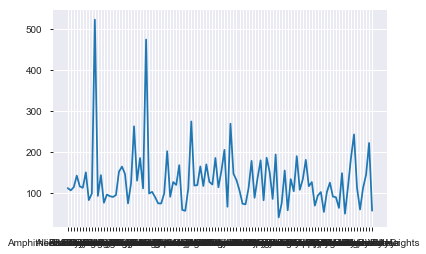

In [96]:
plt.plot(price_vs_neighbor.index,price_vs_neighbor.price)

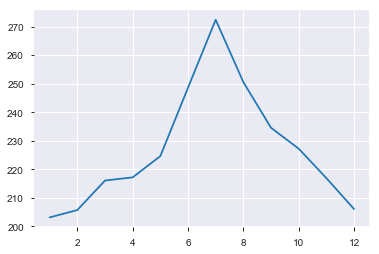

In [97]:
calendar_with_neighbor['month']=calendar_with_neighbor['date'].apply(lambda x: x.month)
price_vs_month = calendar_with_neighbor.groupby(['month']).mean()
plt.plot(price_vs_month.index,price_vs_month.price)


In [98]:
calendar_with_neighbor.groupby(['neighbourhood_cleansed','month']).mean()

price  adjusted_price  minimum_nights  \
neighbourhood_cleansed      month                                               
Allied Gardens              1      110.313620      110.313620        8.543011   
                            2      109.304598      109.304598        8.570881   
                            3      110.661290      110.661290        8.573477   
                            4      110.907407      110.907407        8.570370   
                            5      111.125448      111.125448        8.569892   
                            6      114.316667      114.316667       13.296296   
                            7      118.256272      118.256272       13.301075   
                            8      115.195341      115.195341       13.293907   
                            9      112.605556      112.605556        8.574074   
                            10     110.516129      110.516129        8.568100   
                            11     110.409962      109.877395        8.544061   
                            12     112.641577      111.756272        8.252688   
Alta Vista                  1       98.170507       98.170507        2.000000   
                            2       95.177340       95.177340        2.000000   
                            3       95.000000       95.000000        2.000000   
                            4       95.647619       95.647619        2.000000   
                            5       97.400922       97.400922        2.000000   
                            6      104.695238      104.695238        2.000000   
                            7      124.193548      124.193548        2.000000   
                            8      119.506912      119.506912        2.000000   
                            9      120.152381      120.152381        2.000000   
                            10     118.626728      118.626728        2.000000   
                            11     110.142857      110.142857        2.014778   
                            12     101.119816      101.119816        2.050691   
Amphitheater And Water Park 1      113.677419      113.677419        1.387097   
                            2      113.586207      113.586207        1.379310   
                            3      113.537634      113.537634        1.376344   
                            4      113.422222      113.422222        1.377778   
                            5      113.860215      113.860215        1.387097   
                            6      114.355556      114.355556        1.377778   
                            7      114.397849      114.397849        1.387097   
                            8      114.376344      114.376344        1.376344   
                            9      114.366667      114.366667        1.377778   
                            10     114.419355      114.419355        1.387097   
                            11     116.505747      116.505747        1.379310   
                            12     116.569892      116.569892        1.376344   
Balboa Park                 1      135.893282      135.798821        5.477512   
                            2      139.011989      138.790632        5.022865   
                            3      139.055613      138.812464        5.039773   
                            4      140.823178      140.574074        4.946117   
                            5      144.710718      144.449532        4.946930   
                            6      145.581004      145.316129        4.820550   
                            7      168.845416      168.543184        4.797896   
                            8      145.829113      145.555671        4.826454   
                            9      142.064994      141.812186        4.857228   
                            10     138.925656      138.684241        4.848422   
                            11     136.409962      136.132864        4.876406   
                            12     132.963580      132.936987        5.

In [99]:
def month_to_season(m):
    if m in [12,1,2]: return 4
    elif m in [3,4,5]: return 1
    elif m in [6,7,8]: return 2
    else: return 3
    
calendar_with_neighbor['season']=calendar_with_neighbor['month'].apply(lambda x: month_to_season(x))

In [100]:
price_vs_season = calendar_with_neighbor.groupby(['season']).mean()

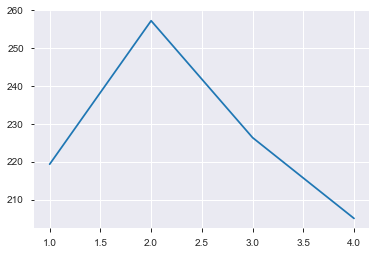

In [101]:
plt.plot(price_vs_season.index,price_vs_season.price)

In [102]:
calendar_with_neighbor.drop(['month'], axis=1).groupby(['neighbourhood_cleansed','season']).mean()

price  adjusted_price  \
neighbourhood_cleansed      season                               
Allied Gardens              1       110.897947      110.897947   
                            2       115.940217      115.940217   
                            3       111.178395      111.006790   
                            4       110.785104      110.483516   
Alta Vista                  1        96.020186       96.020186   
                            2       116.256211      116.256211   
                            3       116.401587      116.401587   
                            4        98.221350       98.221350   
Amphitheater And Water Park 1       113.608696      113.608696   
                            2       114.376812      114.376812   
                            3       115.074074      115.074074   
                            4       114.633700      114.633700   
Balboa Park                 1       141.537518      141.286349   
                            2       153.503701      153.223352   
                            3       139.161489      138.904779   
                            4       135.889125      135.777345   
Bario Logan                 1       117.224638      117.224638   
                            2       117.199275      117.199275   
                            3       116.261111      116.261111   
                            4       114.816850      114.816850   
Bay Ho                      1       112.769057      112.769057   
                            2       114.176172      114.176172   
                            3       113.650938      113.634921   
                            4       110.985586      110.985586   
Bay Park                    1       148.442968      148.314170   
                            2       161.000982      160.871792   
                            3       149.138688      148.981392   
                            4       143.551900      143.481531   
Bay Terrace                 1        82.563718       82.563718   
                            2        83.351574       83.351574   
                            3        83.196935       83.196935   
                            4        82.700644       82.700644   
Bird Land                   1        99.793103       97.909670   
                            2       100.980135       99.266492   
                            3        99.106130       97.584291   
                            4        96.250853       95.176582   
Bonita Long Canyon          1       520.201087      520.201087   
                            2       523.358696      523.358696   
                            3       523.433333      523.433333   
                            4       521.296703      521.296703   
Carmel Mountain             1        90.257246       90.257246   
                            2        96.666667       96.666667   
                            3        95.703704       95.703704   
                            4        89.531136       89.531136   
Carmel Valley               1       142.921113      142.822628   
                            2       146.374506      146.276021   
                            3       144.068519      143.980976   
                            4       141.660839      141.583500   
Chollas View                1        76.936335       76.936335   
                            2        76.503106       76.503106   
                            3        76.885714       76.885714   
                            4        75.984301       75.984301   
City Heights East           1        95.585870       95.525870   
                            2        98.589783       98.519348   
                            3        96.940667       96.882667   
                            4        94.700440       94.653626   
City Heights West           1        91.687830       91.495429   
                            2        95.791548       95.620683   
                            3        91.519003       91.375493   
               

In [103]:
calendar['available'] = calendar['available'].map(lambda x: 1 if x == 't' else 0)

In [104]:
calendar_by_year = calendar.groupby('listing_id').mean()

In [105]:
#new_listing = listings.merge(calendar_by_year, left_on = 'id', right_index = True, how='left')

In [106]:
#new_listing.head()

# 3. Before Model Training

## 3.1 Final check
* **Deleting unwanted columns**
* **Additional data encoding**
* **Data type conversion**
* **Missing value imputation**

In [107]:
listings['if_monthly'] = [0 if pd.isnull(x) else 1 for x in listings['monthly_price']]
listings['kitchen'] = [int(x == True) for x in listings['kitchen']]
listings['distance_min'] = listings[['distance_to_balboa_park','distance_to_san_diego_zoo',
                                    'distance_to_national_monument','distance_to_airport',
                                    'distance_to_seaworld','distance_to_lajolla',
                                    'distance_to_torreybeach','distance_to_sunsetcliff',
                                    'distance_to_convention_center']].min(axis = 1)

## NA: fill mean, or delete row
listings = listings.dropna(subset=['host_listings_count', 'host_has_profile_pic','host_identity_verified','bedrooms'])

listings['host_is_superhost'] = pd.to_numeric(listings['host_is_superhost']) 
listings.fillna(listings.mean(), inplace = True)

In [108]:
listings = listings.reset_index().drop(
    [# id
        'index','id','listing_url','scrape_id','last_scraped',
    # descriptions
        'name','summary','space','description','neighborhood_overview','notes','transit','access',
        'interaction','house_rules','notes_spec','transit_spec','access_spec','interaction_spec',
    # host
        'host_id','host_url','host_name','host_location','host_about','host_response_time','host_response_rate','host_acceptance_rate',
        'host_thumbnail_url','host_picture_url','host_neighbourhood','host_total_listings_count',
        'host_verifications','host_since', #host_verifications??
    # geo
        'street','neighbourhood','neighbourhood_cleansed','neighbourhood_group_cleansed',
        'city','state','zipcode','market','smart_location','country_code','country',
        'latitude','longitude','is_location_exact', 
    # house info
        'property_type','room_type','bed_type','bathrooms','beds', 
        'amenities','square_feet','weekly_price','monthly_price', 
        'security_deposit','cleaning_fee','guests_included','extra_people', ### ?
        'maximum_nights','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights',
        'maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','calendar_updated',
        'has_availability','availability_30','availability_60','availability_90','availability_365','calendar_last_scraped',
    # review
        'first_review','last_review','number_of_reviews_ltm','number_of_reviews_log',
        'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication',
        'review_scores_location','review_scores_value',
    # other
        'requires_license','license','jurisdiction_names','cancellation_policy',
        'require_guest_profile_picture','require_guest_phone_verification',
        'calculated_host_listings_count','calculated_host_listings_count_entire_homes', ### ?
        'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms', ### ?
    # new
        'property_type_encode','descriptC'
        
    ], axis = 1)

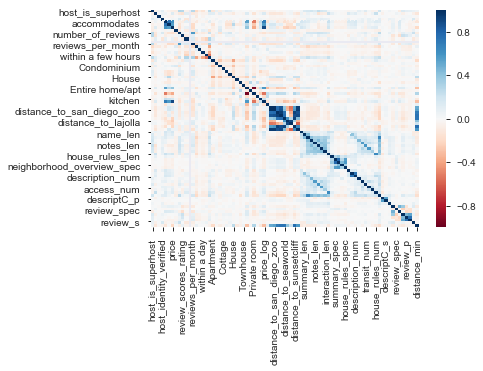

In [109]:
sns.heatmap(listings.corr(),  
            vmin = -1, vmax = 1, center = 0, cmap = 'RdBu')

In [110]:
listings.to_csv("new_listings.csv", index = False)

## 3.2 Train-Validation-Test Splitting

In [111]:
listings2 = listings.copy()

In [4]:
listings = pd.read_csv("new_listings.csv")

In [5]:
#Split training and testing model: 85%
from sklearn.model_selection import train_test_split

model_x = listings.drop(['price','price_log'], axis = 1)
model_y = listings['price_log']

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train is now 75% of the entire data set
train_x, test_x, train_y, test_y = train_test_split(model_x, model_y, 
                                                    test_size = 1 - train_ratio, random_state = 5)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
validate_x, test_x, validate_y, test_y = train_test_split(test_x, test_y, 
                                                    test_size = test_ratio/(test_ratio + validation_ratio),
                                                    random_state = 5) 
print(train_x.shape, validate_x.shape, test_x.shape)

(7519, 77) (1504, 77) (1003, 77)


## 3.3 Scaling: standardization

In [13]:
from sklearn import preprocessing


#Standard scaling
sc_scale = preprocessing.StandardScaler().fit(train_x)

train_x_sc = train_x.copy()     
train_x_sc[:] = sc_scale.transform(train_x_sc[:])

test_x_sc = test_x.copy()
test_x_sc[:] = sc_scale.transform(test_x_sc[:])

validate_x_sc = validate_x.copy()
validate_x_sc[:] = sc_scale.transform(validate_x_sc[:])


#show
train_x_sc.describe()

,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,accommodates,bedrooms,minimum_nights,number_of_reviews,review_scores_rating,instant_bookable,is_business_travel_ready,reviews_per_month,calendar_updated_trans,a few days or more,within a day,within a few hours,within an hour,Apartment,Bungalow,Condominium,Cottage,Guest suite,Guesthouse,House,Loft,Other,Townhouse,Entire home/apt,Hotel room,Private room,Shared room,kitchen,bb_ratio,distance_to_balboa_park,distance_to_san_diego_zoo,distance_to_national_monument,distance_to_airport,distance_to_seaworld,distance_to_lajolla,distance_to_torreybeach,distance_to_sunsetcliff,distance_to_convention_center,name_len,summary_len,description_len,neighborhood_overview_len,notes_len,transit_len,access_len,interaction_len,house_rules_len,name_spec,summary_spec,description_spec,neighborhood_overview_spec,house_rules_spec,name_num,summary_num,description_num,neighborhood_overview_num,notes_num,transit_num,access_num,interaction_num,house_rules_num,svd,descriptC_p,descriptC_s,house_rules_p,review_len,review_spec,review_num,svd_R,review_p,review_s,if_monthly,distance_min
count,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7519.0,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03,7.519000e+03
mean,4.603904e-17,-1.531854e-16,-2.521176e-15,-2.082536e-16,1.011737e-16,8.469530e-17,1.198595e-16,-6.693232e-17,8.560485e-16,1.770687e-16,0.0,1.909336e-16,-2.942039e-17,-8.225086e-16,4.902907e-17,9.628774e-16,-2.445178e-16,7.865027e-16,-2.668286e-16,6.285407e-16,9.435936e-17,-1.302338e-15,-9.548893e-17,6.488581e-16,9.836452e-16,-2.950751e-16,4.704162e-16,-3.944917e-16,3.289584e-16,-3.152153e-16,2.444178e-15,-6.980717e-16,-4.416677e-16,1.349130e-16,-2.510589e-16,-2.055699e-16,-4.622684e-17,1.601916e-16,1.693611e-17,-1.741746e-16,2.933328e-16,1.955699e-17,-1.847320e-16,2.087113e-17,-6.056541e-16,6.290132e-18,-5.528967e-17,-3.381315e-16,3.785707e-17,-2.653280e-17,-1.221112e-16,-5.806116e-16,-4.397924e-17,-3.799457e-16,-2.010633e-16,-2.047098e-16,5.819701e-16,-1.635065e-16,1.513655e-17,2.504979e-16,5.571492e-16,6.278467e-16,8.817702e-16,2.742999e-16,1.655368e-16,-4.342996e-16,1.117606e-16,-1.522293e-16,-2.309039e-16,5.229226e-17,-2.362675e-16,3.646357e-17,-7.778353e-16,4.556471e-16,7.614603e-17,6.743435e-17,-9.121798e-17
std,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,0.0,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.

## 3.4 Write out csv files for building models

In [14]:
####### Standardized Scaling ################
# combine y back with x
train_sc = train_x_sc.copy()
train_sc['price_log'] = train_y

validate_sc = validate_x_sc.copy()
validate_sc['price_log'] = validate_y

test_sc = test_x_sc.copy()
test_sc['price_log'] = test_y

train_validation = train_sc.append(validate_sc, ignore_index = True)

# write out csv files
train_sc.to_csv('train_sc.csv', index = False)
validate_sc.to_csv('validate_sc.csv', index = False)
test_sc.to_csv('test_sc.csv', index = False)
train_validation.to_csv('train_validation_sc.csv', index = False)

# 4. Model Building

In this session, we tried 7 models including: LASSO Regression, Support Vector Regression (SVR), Random Forest, Gradient Boost, Ada Boost, K-Nearest-Neighbor Regression (KNNR), Deep Neural Network.

In [111]:
train = pd.read_csv("train_sc.csv")
validate = pd.read_csv("validate_sc.csv")
test = pd.read_csv("test_sc.csv")

train.shape

(7519, 78)

In [112]:
train_x = train.drop(['price_log'], axis = 1)
train_y = train[['price_log']]

validate_x = validate.drop(['price_log'], axis = 1)
validate_y = validate[['price_log']]

test_x = test.drop(['price_log'], axis = 1)
test_y = test[['price_log']]

## 4.1 Lasso

/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 605.0453955335912, tolerance: 0.3671408891901037
  positive)
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 605.0400640709283, tolerance: 0.3671408891901037
  positive)
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 605.0336422297338, tolerance: 0.3671408891901037
  positive)
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might w

/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 598.0991355304053, tolerance: 0.3671408891901037
  positive)
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 596.661311554072, tolerance: 0.3671408891901037
  positive)
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 594.9240144483308, tolerance: 0.3671408891901037
  positive)
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might wa

/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.937827109730506, tolerance: 0.3671408891901037
  positive)


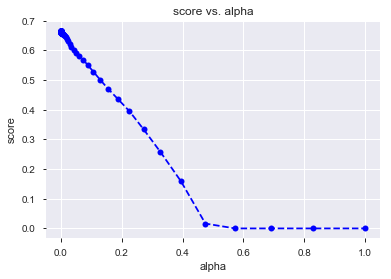

The optimaized alpha and score of Lasso linear is:  1e-08 0.6661802232254836


In [113]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import math

alphas = np.logspace (-8, 0, num=100)
scores = np.empty_like(alphas)
aics = np.empty_like(alphas)
bics = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    lasso = Lasso()
    lasso.set_params(alpha = a)
    lasso.fit(train_x, train_y)
    scores[i] = lasso.score(validate_x, validate_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
        lasso_save = lasso
    
    k = sum(lasso.coef_ != 0)
    aics[i] = 2 * k - 2 * math.log(sum((train_y['price_log'] - lasso.predict(train_x))**2)) 
    
plt.plot(alphas, scores, color='b', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print('The optimaized alpha and score of Lasso linear is: ', opt_a, max_score)

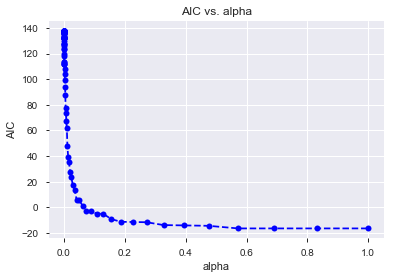

In [114]:
plt.plot(alphas, aics, color='b', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=6)
plt.xlabel('alpha')
plt.ylabel('AIC')
plt.grid(True)
plt.title('AIC vs. alpha')
plt.show()

In [115]:
# combine the validate data and training data, use the optimal alpha, re-train the model
lasso_f = Lasso()
lasso_f.set_params(alpha = opt_a)
lasso_f.fit(train_x, train_y)

# lasso_f is the Lasso model (linear feature), to be tested with final test data.

/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 605.0453955335912, tolerance: 0.3671408891901037
  positive)


Lasso(alpha=1e-08, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

###### Feature Selection by Lasso

In [116]:
lasso_f_coeffs = pd.DataFrame({'name': train_x.columns.tolist(),
                               'coef': lasso_f.coef_,
                               'coef_abs': np.abs(lasso_f.coef_)}) 
lasso_f_coeffs.loc[lasso_f_coeffs['coef'] == 0,:]

,name,coef,coef_abs
10,is_business_travel_ready,0.0,0.0


In [117]:
## combine train + validation, for Cross-Validation later
train_x = train_x.append(validate_x, ignore_index = True)
train_y = train_y.append(validate_y, ignore_index = True)

## drop two variables according to LASSO variable selection and analysis
#train_x = train_x.drop(['is_business_travel_ready'], axis = 1)
#test_x = test_x.drop(['is_business_travel_ready'], axis = 1)

## 4.2 SVM

/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


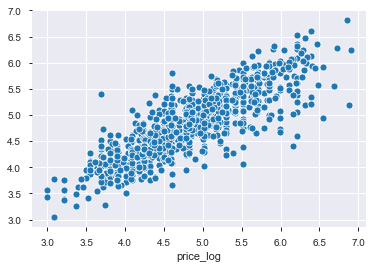

In [118]:
from sklearn.svm import SVR
import sklearn.metrics as sm

# SVR with {'C': 4, 'epsilon': 0.05, 'gamma': 0.0078125} (= 2**-7)
m_svr = SVR(kernel='rbf', C=4, epsilon=0.05, gamma=2**-7).fit(train_x, train_y)
ax = sns.scatterplot(test_y['price_log'], m_svr.predict(test_x).flatten())

## 4.3 Random Forest

In [122]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [240, 260, 280, 300], 
              'max_depth': [48, 50, 80]
             }

rf = RandomForestRegressor(random_state = 2, max_features = 'sqrt')
grid_rf = GridSearchCV(rf, param_grid, cv = 5)
grid_rf.fit(train_x, train_y)

/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation

/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation

/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='sqrt',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=2,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [48, 50, 80],
       

In [123]:
pd.DataFrame(grid_rf.cv_results_).sort_values('mean_test_score', ascending = False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,7.193112,0.194870,0.166558,0.012789,48,300,"{'max_depth': 48, 'n_estimators': 300}",0.724754,0.720013,0.704111,0.736251,0.723486,0.721721,0.010358,1
7,7.126886,0.263205,0.156882,0.009460,50,300,"{'max_depth': 50, 'n_estimators': 300}",0.724754,0.720013,0.704111,0.736251,0.723486,0.721721,0.010358,1
11,6.665685,0.060211,0.151618,0.001695,80,300,"{'max_depth': 80, 'n_estimators': 300}",0.724754,0.720013,0.704111,0.736251,0.723486,0.721721,0.010358,1
1,6.002299,0.186995,0.135330,0.005676,48,260,"{'max_depth': 48, 'n_estimators': 260}",0.724770,0.720262,0.703590,0.737034,0.722642,0.721658,0.010728,4
5,6.349968,0.228523,0.138438,0.004829,50,260,"{'max_depth': 50, 'n_estimators': 260}",0.724770,0.720262,0.703590,0.737034,0.722642,0.721658,0.010728,4
9,5.764088,0.076516,0.131595,0.001748,80,260,"{'max_depth': 80, 'n_estimators': 260}",0.724770,0.720262,0.703590,0.737034,0.722642,0.721658,0.010728,4
2,6.648269,0.164135,0.146364,0.003797,48,280,"{'max_depth': 48, 'n_estimators': 280}",0.724578,0.720382,0.703657,0.736645,0.722824,0.721615,0.010584,7
6,6.635526,0.183243,0.153241,0.007643,50,280,"{'max_depth': 50, 'n_estimators': 280}",0.724578,0.720382,0.703657,0.736645,0.722824,0.721615,0.010584,7
10,6.222743,0.074587,0.142733,0.002238,80,280,"{'max_depth': 80, 'n_estimators': 280}",0.724578,0.720382,0.703657,0.736645,0.722824,0.721615,0.010584,7
0,5.687355,0.183671,0.141167,0.023406,48,240,"{'max_depth': 48, 'n_estimators': 240}",0.724724,0.719921,0.703446,0.736724,0.722626,0.721486,0.010695,10


In [124]:
rf = RandomForestRegressor(random_state = 2, max_features = 'sqrt', 
                           max_depth = grid_rf.best_params_['max_depth'], 
                           n_estimators = grid_rf.best_params_['n_estimators']) #280, 50 #80, 120
rf.fit(train_x, train_y)

/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=48,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=2, verbose=0,
                      warm_start=False)

## 4.4 Gradient Boost

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
#from sklearn.kernel_ridge import KernelRidge
score_objective = "neg_mean_squared_error"

gbr = GradientBoostingRegressor(random_state=0)
grid_values_gbr = {'n_estimators': [20,60,80,100], 'learning_rate' : [0.1], 'max_depth' : [5,6,7,8,9]}
grid_gbr = GridSearchCV(gbr, param_grid = grid_values_gbr, scoring = score_objective, cv=5, n_jobs=16)
grid_gbr.fit(train_x, train_y)
print('Grid best parameter for GradientBoostingRegressor (max. {}): '.format(score_objective), grid_gbr.best_params_)
print('Grid best score ({}): '.format(score_objective), -grid_gbr.best_score_)

In [46]:
params_gbr = {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1}
clf_gbr = GradientBoostingRegressor(**params_gbr)
clf_gbr.fit(train_x,train_y)

/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE of Gradient Boosting Regressor: 0.1254


## 4.5 Ada Boost

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

abr = AdaBoostRegressor(random_state=0)
grid_values_abr = {'n_estimators': [30,40,50,60,70,80,90], 'learning_rate' : [0.1,0.5,1.0,1.5,2.0]}
grid_abr = GridSearchCV(abr, param_grid = grid_values_abr, scoring = score_objective, cv=5, n_jobs=16)
grid_abr.fit(train_x, train_y)
print('Grid best parameter AdaBoostRegressor (max. {}): '.format(score_objective), grid_abr.best_params_)
print('Grid best score ({}): '.format(score_objective), -grid_abr.best_score_)

In [55]:
params_abr = {'n_estimators': 70, 'learning_rate': 0.1}
clf_abr = GradientBoostingRegressor(**params_abr)
clf_abr.fit(train_x,train_y)

/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE of Ada Boost Regressor: 0.1438


## 4.6 KNNR

In [154]:
from sklearn.neighbors import KNeighborsRegressor

grid_result = GridSearchCV(estimator = KNeighborsRegressor(algorithm='brute'),
                    param_grid = dict(n_neighbors = list(range(1,40)),
                                      p = [1, 2]), cv = 5, n_jobs=20).fit(train_x, train_y)
grid_result.best_params_

/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A wor

{'n_neighbors': 9, 'p': 1}

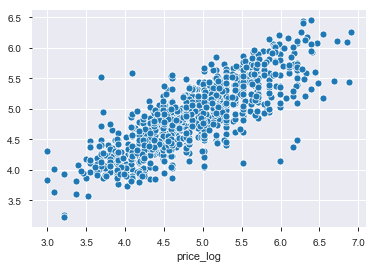

In [161]:
m_knnr = grid_result.best_estimator_
sns.scatterplot(test_y['price_log'], m_knnr.predict(test_x).flatten())

## 4.7 DNN

In [188]:
test['price_log']

0       5.703782
1       6.033086
2       6.212606
3       4.094345
4       3.891820
5       4.787492
6       4.753590
7       5.652489
8       5.459586
9       5.003946
10      4.595120
11      4.174387
12      5.476464
13      4.787492
14      3.806662
15      4.595120
16      4.234107
17      4.770685
18      3.688879
19      4.605170
20      4.615121
21      4.382027
22      3.871201
23      4.317488
24      4.934474
25      4.905275
26      4.369448
27      5.416100
28      4.691348
29      5.010635
30      5.700444
31      5.521461
32      4.859812
33      5.480639
34      5.043425
35      5.273000
36      6.163315
37      4.174387
38      5.393628
39      2.995732
40      4.317488
41      4.317488
42      4.317488
43      4.919981
44      4.574711
45      4.867534
46      4.317488
47      4.304065
48      5.247024
49      3.401197
50      6.396930
51      5.298317
52      4.499810
53      5.645447
54      4.595120
55      4.174387
56      5.298317
57      5.288267
58      5.1357

In [190]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor


train = pd.read_csv('train_sc.csv', low_memory=False)
validate = pd.read_csv('validate_sc.csv', low_memory=False)
test = pd.read_csv('test_sc.csv', low_memory=False)
train_validate = pd.concat([train, validate])

X_train = train.drop(['price_log'], axis=1)
X_validate = validate.drop(['price_log'], axis=1)

# https://www.tensorflow.org/tutorials/keras/regression
# https://stackoverflow.com/questions/55924789/normalization-of-input-data-in-keras

# need to 'pickle' model creation to allow for multiprocess parallel execution for grid search
# see https://github.com/keras-team/keras/issues/6862
def create_model(neurons):
    m = keras.Sequential([
        layers.BatchNormalization(),
        layers.Dense(neurons, activation='relu', input_shape=[X_train.shape[1]]),
        layers.Dropout(0.2),
        layers.BatchNormalization(),
        layers.Dense(neurons, activation='relu'),
        layers.Dropout(0.2),
        layers.BatchNormalization(),
        layers.Dense(neurons, activation='relu'),
        layers.Dense(1)
    ])
    m.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse']) # also sgd, keras.optimizers.RMSprop
    return m


# test the model
m = create_model(64)
m.fit(X_train,
    train.price_log.to_numpy(),
    epochs=900,
    batch_size=512,
    validation_data=(X_validate, validate.price_log.to_numpy()),
    verbose = 1)
m.summary()

AttributeError: 'Series' object has no attribute 'to_numpy'

# 5. Model Evaluation

* Based on R-square or MSE, **Gradient Boost (R-square: 0.74)** shows the best result. Random Forest also gives decent result.
* Lasso Regression serves as our base model (R-square: 0.66)
* Deep learning doesn't perform well due to the limited data size

In [137]:
score_lasso = lasso_f.score(test_x, test_y)
pred_y = lasso_f.predict(test_x)

# The mean squared error and root mean square error
MSE_lasso = mean_squared_error(test_y, pred_y)
RMSE_lasso = sqrt(mean_squared_error(test_y, pred_y))

print('LASSO R^2: %.4f' % score_lasso)
print('LASS MSE: %.4f' % MSE_lasso)
print('LASSO RMSE: %.4F' % MSE_lasso)

LASSO R^2: 0.6603
LASS MSE: 0.1629
LASSO RMSE: 0.1629


In [138]:
score_svr = m_svr.score(test_x, test_y)
MSE_svr = sm.mean_squared_error(test_y, m_svr.predict(test_x).flatten())

print("SVR R^2: %.4f" % score_svr)
print("SVR MSE: %.4f" % MSE_svr)

SVR R^2: 0.7122
SVR MSE: 0.1380


In [139]:
score_rf = rf.score(test_x, test_y)

pred_y = rf.predict(test_x)
MSE_rf = mean_squared_error(test_y, pred_y)
RMSE_rf = sqrt(mean_squared_error(test_y, pred_y))

# The mean squared error and root mean square error
print('RF R^2: %.4f' % rf_score) 
print('RF R^2: %.4f' % MSE_rf) 
print('RF R^2: %.4f' % RMSE_rf) 

RF R^2: 0.7365
RF R^2: 0.1275
RF R^2: 0.3570


In [140]:
score_gbr = clf_gbr.score(test_x, test_y)
MSE_gbr = mean_squared_error(test_y, clf_gbr.predict(test_x))

print("GradientBoost R^2: %.4f" % score_gbr)
print("GradientBoost MSE: %.4f" % MSE_gbr)

GradientBoost R^2: 0.7386
GradientBoost MSE: 0.1254


In [141]:
score_abr = clf_abr.score(test_x, test_y)
MSE_abr = mean_squared_error(test_y, clf_abr.predict(test_x))

print("AdaBoost R^2: %.4f" % score_abr)
print("AdaBoost MSE: %.4f" % MSE_abr)

AdaBoost R^2: 0.7000
AdaBoost MSE: 0.1438


In [162]:
score_knnr = m_knnr.score(test_x, test_y)
MSE_knnr = mean_squared_error(test_y, m_knnr.predict(test_x))

print("KNNR R^2: %.4f" % score_knnr)
print("KNNR MSE: %.4f" % MSE_knnr)

KNNR R^2: 0.6715
KNNR MSE: 0.1575


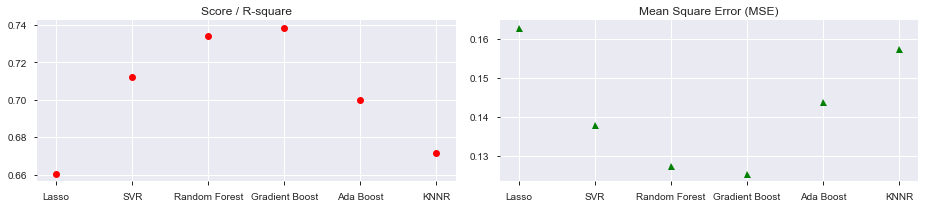

In [176]:
score_lst = [score_lasso, score_svr, score_rf, score_gbr, score_abr, score_knnr]
MSE_lst = [MSE_lasso, MSE_svr, MSE_rf, MSE_gbr, MSE_abr, MSE_knnr]
model_lst = ['Lasso', 'SVR', 'Random Forest', 'Gradient Boost', 'Ada Boost', 'KNNR']

fig, axs = plt.subplots(1, 2, figsize = (13, 3))

axs[0].plot(model_lst, score_lst, 'ro')
axs[0].set_title('Score / R-square')

axs[1].plot(model_lst, MSE_lst, 'g^')
axs[1].set_title('Mean Square Error (MSE)')

fig.tight_layout()
plt.show()

# 6. Feature Importance

* LASSO and Random Forest shows relatively consistent feature importance ranking
* The most important two types of features are:
    * The most important features are **House Basic Info** (*# accommodates, # bedrooms, whether it is entire apt, private room, and the bathroom_bedroom ratio* we created)
    * The second most important features are **Location Info** (*distance to landscapes like La Jolla, Sea World, Sunset Cliff, Balboa Park, Torrey Beach, Convention Center*)
* *The Number of Reviews Per Month* from **Reviews Info** is an important predictor based on both method.
* Based on RF, **Listing Description Info** like *Length of Name, Length of Summary* are also important. Based on LASSO, **Hosts Information** like *Reply time, Listing Count* are important. We think it is because these hosts are more serious about renting their houses and put more thoughts and time.

### 6.1 From Lasso

In [177]:
lasso_f_coeffs.sort_values(['coef_abs'], ascending = False).head(20)

,name,coef,coef_abs
35,distance_to_national_monument,0.998831,0.998831
40,distance_to_sunsetcliff,-0.854785,0.854785
41,distance_to_convention_center,-0.460505,0.460505
33,distance_to_balboa_park,0.375434,0.375434
39,distance_to_torreybeach,0.267728,0.267728
4,accommodates,0.213740,0.213740
27,Entire home/apt,0.195211,0.195211
76,distance_min,-0.182848,0.182848
37,distance_to_seaworld,0.145878,0.145878
5,bedrooms,0.141138,0.141138


### 6.2 From RF

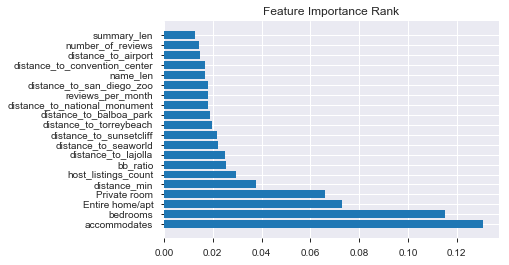

In [178]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
feature_name = test_x.columns.get_values()

importance_df = pd.DataFrame({'name': feature_name, 'importance': importances})
importance_df['YN'] = [x[:12] == 'PULocationID' for x in importance_df.name.values]
importance_df.append({'importance':sum(importance_df.loc[importance_df.YN].importance), 
                      'name':'PULocationID',
                      'YN': False}, ignore_index=True)
importance_df = importance_df.loc[importance_df.YN == False].sort_values(['importance'], ascending = False).iloc[0:20,]

plt.figure(1)
plt.barh(np.arange(importance_df.shape[0]), importance_df.importance)
plt.yticks(np.arange(importance_df.shape[0]), importance_df.name)
plt.title('Feature Importance Rank')
plt.show()